# Dynamic LLM Query Router

**Project:** Dynamic LLM Query Router (DLQR) for Multi-Model Orchestration
**Author:** Pranshu Goyal  
**Date:** 2025-08-16  
**Environment:** Python ≥ 3.10  

---

## Abstract
This notebook presents a consolidated, production-oriented implementation of a **Dynamic LLM Query Router (DLQR)**, designed for multimodal healthcare queries and decision support.  
The system routes user queries dynamically across three specialized modules:  

- **Prediction** — supervised classification using biomarkers and patient metadata.  
- **Case-Based Reasoning (CBR)** — retrieval and ranking of similar historical cases.  
- **Retrieval-Augmented Generation (RAG)** — large language model–driven question answering and summarisation.  

The router employs advanced mechanisms for **temperature calibration, circuit-breaking, hedging, and bandit-based exploration**, ensuring robust performance under uncertainty. Integrated utilities support preprocessing, dataset management, supervised training, and artifact persistence, enabling full end-to-end experimentation.

---

## Execution Instructions
1. **Environment Setup:** Create and activate a clean Python virtual environment.  
2. **Notebook Runtime:** Open in JupyterLab or VS Code with the correct kernel.  
3. **Configuration:** Ensure a `.env` file is present in the working directory (see provided template).  
4. **Execution Order:** Run the notebook sequentially from top to bottom. All modules degrade gracefully if artifacts are missing, emitting warnings instead of failing.  

> **Note:** On first execution, some components (e.g., Ollama LLM backends, Sentence-Transformer embeddings) may automatically download pretrained weights. If required artifacts for Prediction/CBR/RAG are absent, the corresponding tools will provide clear diagnostic messages while the router itself continues to operate.

In [2]:
# ==============================
# 1) Environment Setup 
# ==============================

# %pip install -U -qq \
#   python-dotenv==1.0.1 \
#   rich==13.9.4 \
#   loguru==0.7.2 \
#   tqdm==4.66.5 \
#   numpy==1.26.4 \
#   pandas==2.2.3 \
#   scipy==1.11.4 \
#   scikit-learn==1.5.2 \
#   matplotlib==3.9.2 \
#   seaborn==0.13.2 \
#   joblib==1.4.2 \
#   torch==2.4.1 \
#   sentence-transformers==3.0.1 \
#   xgboost==2.1.1 \
#   "accelerate>=0.26.0" \
#   "transformers>=4.41,<5" \
#   "pydantic>=2,<3" \
#   "llama-index>=0.11,<0.12" \
#   "llama-index-llms-ollama>=0.3,<0.4" \
#   "llama-index-embeddings-huggingface>=0.3,<0.4"

# print("Pip Dependencies Installed Successfully.")

# %conda install -y -q -c conda-forge faiss-cpu=1.7.4

# print("Conda Dependencies Installed Successfully.")

In [3]:
# ==============================
# 2) Imports 
# ==============================

from __future__ import annotations

# --- Warnings ---
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# --- Standard library ---
import html
import hashlib
import inspect
import re
import asyncio
import concurrent.futures as _fut
from collections import Counter, defaultdict, deque
from dataclasses import dataclass, field, asdict
from enum import Enum
import json
import math
import os
from pathlib import Path
import random
import shutil
import sys
import threading as _thread
import time
import traceback
import uuid
from typing import Any, Callable, Dict, List, Optional, Tuple, Sequence, Iterable, Union
from urllib.parse import unquote

# --- Third-party ---
from dotenv import load_dotenv
import faiss
import joblib
import numpy as np
import pandas as pd
from pydantic import BaseModel, Field
from scipy.stats import multivariate_normal
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)
import xgboost  
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from llama_index.core import (
    Settings,
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
    load_index_from_storage,
)
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

import matplotlib.pyplot as plt

# Make tokenizers deterministic on CPU-only notebooks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("Imports OK. Python:", sys.version.split()[0])

/Users/pranshugoyal/anaconda3/envs/AI-Thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports OK. Python: 3.10.14


---
## Configuration & Environment Setup

This code sets up **environment variables, project directories, random seeds, and model/router configurations**.  
It prepares the system for reproducible ML experiments and defines key parameters for the **Dynamic LLM Query Router** pipeline.

In [ ]:
# -------------------------------
# 🌍 Environment Setup
# -------------------------------

# Load environment variables from a .env file (if present)
# This allows project configuration without hardcoding values
load_dotenv()


# -------------------------------
# 📂 Project Directories
# -------------------------------

# Root directory of the project (defaults to current dir ".")
ROOT_DIR: Path = Path(os.getenv("ROOT_DIR", ".")).resolve()

# Data directory where input/output artifacts are stored
# If "ROUTER_DATA_DIR" is not set, defaults to ./data
DATA_DIR: Path = Path(os.getenv("ROUTER_DATA_DIR", "data")).resolve()

# Create the data directory if it doesn’t exist
DATA_DIR.mkdir(parents=True, exist_ok=True)


# -------------------------------
# 🎲 Reproducibility (Random Seeds)
# -------------------------------

# Global random seed for reproducibility
RANDOM_SEED: int = int(os.getenv("RANDOM_SEED", "42"))

# Function to enforce deterministic behavior across Python, NumPy, and Torch
def set_seed(seed: int = RANDOM_SEED) -> None:
    random.seed(seed)          # Python built-in random module
    np.random.seed(seed)       # NumPy random generator
    torch.manual_seed(seed)    # Torch RNG (CPU & GPU if applicable)

# Set seed immediately after definition
set_seed()


# -------------------------------
# 🔧 Router / Model Configuration
# -------------------------------

# Embedding model used for vectorization of queries (default: MiniLM)
EMBED_MODEL: str = os.getenv("EMBED_MODEL", "all-MiniLM-L6-v2")

# Threshold for uncertainty-based decisions in router
UNCERTAINTY_T: float = float(os.getenv("UNCERTAINTY_T", "0.60"))

# Number of hash bits for locality-sensitive hashing (2^6 = 64 buckets)
HASH_BITS: int = int(os.getenv("BUCKET_HASH_BITS", "6"))

# Whether to use learned (adaptive) buckets instead of static
LEARNED_BUCKETS: bool = bool(int(os.getenv("LEARNED_BUCKETS", "1")))

# Number of clusters used in unsupervised router grouping
N_CLUSTERS: int = int(os.getenv("N_CLUSTERS", "5"))

# -------------------------------
# 🤖 LLM Backbone Configuration
# -------------------------------

# Whether to use LLM-based intent classification in routing
USE_LLM_INTENT: bool = bool(int(os.getenv("USE_LLM_INTENT", "1")))

# Backbone language model for LLM classifier
LLM_BACKBONE: str = os.getenv("LLM_BACKBONE", "distilbert-base-uncased")

# Weight assigned to LLM classifier in ensemble decisions
LLM_WEIGHT: float = float(os.getenv("LLM_WEIGHT", "0.70"))

# -------------------------------
# 🔄 Execution & Hedging Policies
# -------------------------------

# Use multi-model executor (placeholder wiring point, default off)
USE_MM_EXECUTOR: bool = bool(int(os.getenv("USE_MM_EXECUTOR", "0")))

# Whether to apply hedging (sending query to multiple targets if uncertain)
USE_HEDGING: bool = bool(int(os.getenv("USE_HEDGING", "1")))

# Secondary uncertainty threshold for hedging
HEDGE_UNCERTAINTY_T: float = float(os.getenv("HEDGE_UNCERTAINTY_T", "0.25"))

# Maximum number of alternative targets allowed in hedging
HEDGE_MAX_TARGETS: int = int(os.getenv("HEDGE_MAX_TARGETS", "2"))

# Default timeout (ms) when waiting for a target model’s response
DEFAULT_TARGET_TIMEOUT_MS: int = int(os.getenv("TARGET_TIMEOUT_MS", "60000"))


# -------------------------------
# 📁 Derived Paths (Artifacts & Checkpoints)
# -------------------------------

# These are auto-derived from ROOT_DIR and DATA_DIR, stored as strings
# to remain compatible with libraries expecting raw paths.

LOG_Path: str = str(DATA_DIR / "router_events.jsonl")        # Router event logs
POLICY_Path: str = str(DATA_DIR / "policy.pt")               # Learned routing policy
CALIB_Path: str = str(DATA_DIR / "temperature.json")         # Temperature calibration
BANDIT_STATE_Path: str = str(DATA_DIR / "lints_state.json")  # Bandit state checkpoint
LLM_DIR: str = str(DATA_DIR / "llm_intent")                  # Directory for LLM intent model
CSV_Path = str(DATA_DIR / "router_training_dataset.csv")     # Training dataset for router
SPLIT_Path = str(DATA_DIR / "router_splits.json")            # Dataset split metadata
MODEL_DIR = str(ROOT_DIR / "trained_router_llm_nometa_v1")   # Trained router model storage
REPORTS_DIR = str(ROOT_DIR / "reports")                      # Experiment reports


# -------------------------------
# 🖥️ Device Configuration
# -------------------------------

# Force computation on CPU (changeable if CUDA available)
DEVICE = torch.device("cpu")

# Sanity check: print key runtime paths & device info
print("DATA_DIR:", DATA_DIR)
print("Device:", DEVICE)

DATA_DIR: /Users/pranshugoyal/Downloads/Query Router 17-August-2025 3/data
Device: cpu


---
## Router Dataset Preprocessing Module

This module provides **data cleaning, normalization, validation, deduplication, and reporting** for the **Dynamic LLM Query Router** training dataset.  
It ensures consistent schema (`query`, `context`, `label`) while enforcing label rules and removing noisy/invalid samples.

In [ ]:
# -------------------------------
# 📦 Preprocess Configuration
# -------------------------------
@dataclass(frozen=True)
class PreprocessConfig:
    # Column names for text, context, and labels
    text_col: str = "query"
    context_col: str = "context"
    label_col: str = "label"

    # --- Cleaning toggles ---
    lowercase: bool = True          # Convert text to lowercase
    strip_whitespace: bool = True   # Trim leading/trailing spaces
    normalize_space: bool = True    # Replace multiple spaces with single space
    unescape_html: bool = True      # Convert HTML entities (&amp; → &)
    remove_urls: bool = True        # Strip URLs from text
    remove_emails: bool = True      # Strip email addresses
    normalize_quotes: bool = True   # Convert fancy quotes to ASCII equivalents

    # --- Label normalization / validation ---
    force_lower_labels: bool = True                         # Enforce lowercase labels
    allowed_labels: Tuple[str, ...] = ("prediction", "cbr", "qa", "summarize")  
    # Restrict to these canonical labels
    label_map: Optional[Dict[str, str]] = None              # Map synonyms (e.g. "summarise" → "summarize")

    # --- Length filters ---
    min_text_chars: int = 3         # Drop too-short queries
    max_text_chars: int = 5000      # Cap overly long queries
    max_context_chars: int = 8000   # Cap context size

    # --- Deduplication ---
    dedupe_by: Tuple[str, ...] = ("query", "context", "label")

    # --- Context handling ---
    treat_empty_context_as_none: bool = True


# -------------------------------
# 🔍 Regex & Helpers for Cleaning
# -------------------------------
_url_re = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)  # Match URLs
_email_re = re.compile(r"\b\S+@\S+\.\S+\b")                    # Match emails
_whitespace_re = re.compile(r"\s+")                            # Match multi-space
_quotes_map = str.maketrans({"“": '"', "”": '"', "’": "'", "‘": "'", 
                             "„": '"', "‛": "'", "‹": "<", "›": ">"})

def _clean_text(s: Any, cfg: PreprocessConfig, is_context: bool = False) -> Optional[str]:
    """
    Clean text or context according to config toggles.
    Handles NaNs, HTML entities, quotes, URLs, emails, whitespace, casing,
    and length restrictions.
    """
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return None
    s = str(s)
    if cfg.unescape_html:
        s = html.unescape(s)
    if cfg.normalize_quotes:
        s = s.translate(_quotes_map)
    if cfg.remove_urls:
        s = _url_re.sub(" ", s)
    if cfg.remove_emails:
        s = _email_re.sub(" ", s)
    if cfg.strip_whitespace:
        s = s.strip()
    if cfg.normalize_space:
        s = _whitespace_re.sub(" ", s)
    if cfg.lowercase:
        s = s.lower()

    # --- Enforce length limits ---
    if not is_context:
        if len(s) < cfg.min_text_chars:
            return None
        if len(s) > cfg.max_text_chars:
            s = s[: cfg.max_text_chars]
    else:
        if len(s) > cfg.max_context_chars:
            s = s[: cfg.max_context_chars]

    # Handle empty contexts
    if cfg.treat_empty_context_as_none and is_context and (s == "" or s.isspace()):
        return None
    return s


# -------------------------------
# 🧹 Main Preprocessing Function
# -------------------------------
def preprocess_router_dataframe(df_raw: pd.DataFrame, cfg: PreprocessConfig) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """Return a cleaned dataframe + audit report. Includes label normalization and validation."""

    report: Dict[str, Any] = {}

    # --- Validate required columns ---
    needed = [cfg.text_col, cfg.context_col, cfg.label_col]
    missing = [c for c in needed if c not in df_raw.columns]
    if missing:
        raise ValueError(f"Missing required columns in CSV: {missing}")

    df = df_raw.copy()

    # --- LABEL NORMALIZATION ---
    labels = df[cfg.label_col].astype(str)
    if cfg.force_lower_labels:
        labels = labels.str.strip().str.lower()
    if cfg.label_map:  # Remap synonyms if provided
        labels = labels.map(lambda x: cfg.label_map.get(x, x))

    # Validate against allowed labels
    allowed = set(cfg.allowed_labels)
    mask_valid = labels.isin(allowed)
    dropped_invalid = int((~mask_valid).sum())
    if dropped_invalid > 0:
        df = df[mask_valid].copy()
    df[cfg.label_col] = labels.loc[df.index].values
    report["dropped_invalid_labels"] = dropped_invalid

    # --- TEXT / CONTEXT CLEAN ---
    df["__text__"] = df[cfg.text_col].map(lambda x: _clean_text(x, cfg, is_context=False))
    df["__ctx__"] = df[cfg.context_col].map(lambda x: _clean_text(x, cfg, is_context=True))

    # Drop empty or too-short text
    n0 = len(df)
    df = df[df["__text__"].notna() & df[cfg.label_col].notna()]
    report["dropped_empty_or_short"] = int(n0 - len(df))

    # --- DEDUPLICATION ---
    if cfg.dedupe_by:
        key_cols = []
        for c in cfg.dedupe_by:
            if c == cfg.text_col:
                key_cols.append("__text__")
            elif c == cfg.context_col:
                key_cols.append("__ctx__")
            else:
                key_cols.append(c)
        n_before = len(df)
        df = df.drop_duplicates(subset=key_cols, keep="first")
        report["dropped_duplicates"] = int(n_before - len(df))

    # --- FINALIZE SCHEMA ---
    df = df.assign(query=df["__text__"], context=df["__ctx__"]).drop(columns=["__text__", "__ctx__"])
    cols = ["query", "context", cfg.label_col] + [c for c in df.columns if c not in {"query", "context", cfg.label_col}]
    df = df[cols].reset_index(drop=True)

    # --- REPORT ---
    report["class_distribution"] = df[cfg.label_col].value_counts().to_dict()
    report["final_rows"] = int(len(df))
    report["preprocess_config"] = asdict(cfg)
    return df, report


# -------------------------------
# 📊 Reporting Utilities
# -------------------------------
def _maybe_display_df(df: pd.DataFrame, title: Optional[str] = None) -> None:
    """Pretty-print a DataFrame in Jupyter (hide index), fallback to console if unavailable."""
    try:
        from IPython.display import display, HTML  # type: ignore
        if title:
            display(HTML(f"<h4 style='margin:8px 0'>{title}</h4>"))
        display(df.style.hide(axis="index"))  # Cleaner look
    except Exception:
        if title:
            print(f"\n{title}")
        print(df.to_string(index=False))


def _dict_to_kv_df(d: Dict[str, Any], key_col: str, val_col: str) -> pd.DataFrame:
    """Convert a dict into a tidy 2-column DataFrame for display."""
    rows = []
    for k, v in d.items():
        if isinstance(v, (list, tuple, set)):
            v = ", ".join(map(str, v))
        rows.append({key_col: k, val_col: v})
    return pd.DataFrame(rows)


def _show_preprocess_report(report: Dict[str, Any]) -> None:
    """Render audit report: metrics, class distribution, and config settings."""
    rpt = dict(report)  # shallow copy
    class_dist = rpt.pop("class_distribution", None)
    cfg = rpt.pop("preprocess_config", None)

    # 1. Metrics summary
    metrics_df = _dict_to_kv_df(rpt, "Metric", "Value")
    if not metrics_df.empty:
        metrics_df["Metric"] = metrics_df["Metric"].str.replace("_", " ").str.title()
        _maybe_display_df(metrics_df, "🧹 Preprocess Report")

    # 2. Class distribution
    if isinstance(class_dist, dict) and class_dist:
        dist_df = pd.DataFrame(
            [{"Label": k, "Count": int(v)} for k, v in class_dist.items()]
        ).sort_values("Count", ascending=False)
        _maybe_display_df(dist_df, "📊 Class Distribution")

    # 3. Config details
    if isinstance(cfg, dict) and cfg:
        cfg_df = _dict_to_kv_df(cfg, "Setting", "Value").sort_values("Setting")
        _maybe_display_df(cfg_df, "⚙️ Preprocess Config")


# -------------------------------
# 🚀 Public Loader API
# -------------------------------
DEFAULT_PREPROC = PreprocessConfig(text_col="query", context_col="context", label_col="label")

def load_router_dataset_preprocessed(
    csv_Path: str, preprocess_cfg: Optional[PreprocessConfig] = None
):
    """
    Load, preprocess, and summarize a router dataset from CSV.
    Returns cleaned DataFrame + config used.
    """
    raw_df = pd.read_csv(csv_Path)
    cfg = preprocess_cfg or DEFAULT_PREPROC

    df_clean, report = preprocess_router_dataframe(raw_df, cfg)

    # Render audit report and sample rows
    _show_preprocess_report(report)
    try:
        _maybe_display_df(df_clean.head(5), "🔎 Sample Of Cleaned Rows")
    except Exception:
        pass

    return df_clean, cfg


# -------------------------------
# ✅ Ready Message
# -------------------------------
print("Data loader ready.")

Data loader ready.


---
## Router Data Preprocessing (Usage Example)

This snippet demonstrates how to:
1. Define a **preprocessing configuration** for the router dataset.  
2. Load and preprocess the CSV dataset using that configuration.  
3. Return both the cleaned dataframe (`df`) and the effective configuration (`cfg`).  

In [ ]:
# -------------------------------
# Preprocessing Configuration
# -------------------------------
# Define a preprocessing config object with key toggles.
# These settings determine how raw dataset rows (query, context, label) are cleaned.
PREPROC = PreprocessConfig(
    text_col="query",            # Column in CSV containing user queries
    context_col="context",       # Column containing optional context (background text)
    label_col="label",           # Column containing task label (prediction/cbr/qa/summarize)

    # --- Cleaning rules ---
    lowercase=True,              # Convert all text to lowercase
    remove_urls=True,            # Strip URLs from text
    remove_emails=True,          # Strip email addresses
    normalize_space=True,        # Replace multiple spaces/tabs with single space

    # --- Deduplication ---
    dedupe_by=("query", "context", "label"),  # Ensure uniqueness by combination of these columns

    # --- Label handling ---
    label_map=None               # Optional mapping for label synonyms (e.g. {"summarise": "summarize"})
)


# -------------------------------
# Load & Preprocess Dataset
# -------------------------------
# Apply the defined config to load + preprocess router training data.
# - Cleans text/context
# - Normalizes and validates labels
# - Deduplicates rows
# - Produces an audit report (printed as tables if in Jupyter)
#
# Returns:
#   df  → Cleaned Pandas DataFrame (ready for model training/evaluation)
#   cfg → Final preprocessing config actually applied
df, cfg = load_router_dataset_preprocessed(CSV_Path, preprocess_cfg=PREPROC)

Metric,Value
Dropped Invalid Labels,0
Dropped Empty Or Short,0
Dropped Duplicates,0
Final Rows,10240


Label,Count
prediction,2560
cbr,2560
qa,2560
summarize,2560


Setting,Value
allowed_labels,"prediction, cbr, qa, summarize"
context_col,context
dedupe_by,"query, context, label"
force_lower_labels,True
label_col,label
label_map,None
lowercase,True
max_context_chars,8000
max_text_chars,5000
min_text_chars,3


query,context,label,id
"estimate oral cancer risk from biomarkers: mmp9 353, il-8 37.",None,prediction,6a5184809296dc8e
retrieve top-3 similar oscc cases (cbr). focus: mmp-9. [caseid:26c7e73d],None,cbr,602e40f2add97875
q: what do these findings imply for oscc risk/staging? focus: mmp-9. [caseid:26c7e73d],None,qa,ef26d3217e50f82e
summarize the oscc clinical context and biomarker profile into key points. focus: mmp-9. [caseid:26c7e73d],None,summarize,722c9bb1de320775
"estimate oral cancer risk from biomarkers: mmp9 477, il-8 61.","discharge note: continue ace inhibitor, repeat labs in 2 weeks, nephrology referral if egfr < 45.",prediction,7ab0360bccc31abc


## Dataset Splitting Module

This module handles **canonical train/validation/test splits** for the router dataset.  
Key features:
- Uses **SHA-256 hashing** to detect changes in CSV or preprocessing config.  
- Ensures **stratified splits** by label distribution.  
- Caches splits in a JSON file for reproducibility.  
- Regenerates splits if the dataset or preprocessing config changes.  

In [ ]:
# -------------------------------
# 🔐 SHA-256 Hashing Utilities
# -------------------------------
def _sha256_file(Path: str, chunk_size: int = 1 << 20) -> str:
    """
    Compute SHA-256 hash of a file.
    Used to detect changes in dataset CSV.
    """
    h = hashlib.sha256()
    with open(Path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()


def _sha256_text(s: str) -> str:
    """
    Compute SHA-256 hash of a text string.
    Used to fingerprint preprocessing configs.
    """
    return hashlib.sha256(s.encode("utf-8")).hexdigest()


# -------------------------------
# ⚙️ Split Configuration
# -------------------------------
@dataclass(frozen=True)
class RouterSplitConfig:
    """
    Configuration for dataset splitting.
    - csv_Path: Path to cleaned/preprocessed CSV
    - split_Path: Path to JSON file storing canonical splits
    - label_col: Column used for stratified splitting
    - val_size: Fraction of data reserved for validation
    - test_size: Fraction of data reserved for test set
    - seed: Random seed for reproducibility
    - preprocess: Optional preprocessing config to apply before splitting
    """
    csv_Path: str
    split_Path: str  # e.g., DATA_DIR/'router_splits.json'
    label_col: str = "label"
    val_size: float = 0.20
    test_size: float = 0.15
    seed: Optional[int] = None
    preprocess: Optional[PreprocessConfig] = None


# -------------------------------
# 📊 Stratified Split Generator
# -------------------------------
def _make_stratified_splits(y: Sequence, val_size: float, test_size: float, seed: int) -> Dict[str, List[int]]:
    """
    Create stratified train/val/test splits.
    Preserves class distribution across splits.
    """
    idx = np.arange(len(y))

    # First split: Test set
    if test_size and test_size > 0:
        idx_tmp, idx_test = train_test_split(idx, test_size=test_size, random_state=seed, stratify=y)
        y_tmp = [y[i] for i in idx_tmp]
    else:
        idx_tmp, idx_test = idx, np.array([], dtype=int)
        y_tmp = y

    # Second split: Validation set (relative to train size)
    if val_size and val_size > 0:
        rel_val = val_size if not test_size else val_size / (1.0 - test_size)
        idx_train, idx_val = train_test_split(idx_tmp, test_size=rel_val, random_state=seed, stratify=y_tmp)
    else:
        idx_train, idx_val = idx_tmp, np.array([], dtype=int)

    return {
        "train": [int(i) for i in idx_train],
        "val": [int(i) for i in idx_val],
        "test": [int(i) for i in idx_test],
    }


# -------------------------------
# 📂 Get or Create Splits
# -------------------------------
def get_or_create_splits(cfg: RouterSplitConfig, *, force: bool = False) -> Dict[str, List[int]]:
    """
    Build (or load) a canonical split manifest on the **preprocessed** dataframe.
    Regenerates splits if:
      - CSV file changes (detected via SHA-256 hash)
      - Preprocessing config changes (detected via SHA-256 hash)
      - `force=True` is specified
    Returns dictionary with 'train', 'val', 'test' indices.
    """
    csv_Path = Path(cfg.csv_Path)
    split_Path = Path(cfg.split_Path)
    split_Path.parent.mkdir(parents=True, exist_ok=True)

    # Hash CSV to detect modifications
    csv_sha = _sha256_file(str(csv_Path))
    seed = cfg.seed if cfg.seed is not None else RANDOM_SEED

    # Apply preprocessing before splitting (ensures stratification on clean labels)
    raw_df = pd.read_csv(csv_Path)
    pre_cfg = cfg.preprocess or PreprocessConfig(text_col="query", context_col="context", label_col=cfg.label_col)
    df_clean, prep_report = preprocess_router_dataframe(raw_df, pre_cfg)
    prep_fingerprint = _sha256_text(json.dumps(prep_report["preprocess_config"], sort_keys=True))

    # Metadata stored alongside split indices
    desired_meta = {
        "csv_Path": str(csv_Path.resolve()),
        "csv_sha256": csv_sha,
        "label_col": cfg.label_col,
        "val_size": cfg.val_size,
        "test_size": cfg.test_size,
        "seed": int(seed),
        "format_version": 2,
        "preprocess_sha256": prep_fingerprint,
    }

    # --- Load existing split if valid ---
    if split_Path.exists() and not force:
        try:
            saved = json.loads(split_Path.read_text())
            meta_ok = all(saved.get("meta", {}).get(k) == v for k, v in desired_meta.items())
            if meta_ok and {"train", "val", "test"} <= set(saved.get("indices", {}).keys()):
                return saved["indices"]
        except Exception:
            pass

    # --- Otherwise regenerate stratified splits ---
    labels_for_strat = df_clean[cfg.label_col].tolist()
    indices = _make_stratified_splits(labels_for_strat, cfg.val_size, cfg.test_size, seed)

    # Save new split manifest
    out = {"meta": desired_meta, "indices": indices}
    split_Path.write_text(json.dumps(out, indent=2))
    print(f"🗂️  Saved canonical splits to: {split_Path}")
    return indices


# -------------------------------
# ✅ Ready Message
# -------------------------------
print("Data Splitter ready.")

Data Splitter ready.


## Build or Load Canonical Dataset Splits

This snippet shows how to configure and run the **canonical train/validation/test split process** on the **preprocessed dataset**.  

Steps:
1. Define a `RouterSplitConfig` with CSV path, split manifest path, and preprocessing config.  
2. Call `get_or_create_splits()` to either **load cached splits** (if valid) or **regenerate stratified splits** (if dataset or config changed).  
3. Receive a dictionary with index lists for `"train"`, `"val"`, and `"test"`.  

In [ ]:
# -------------------------------
# ⚙️ Split Configuration
# -------------------------------
split_cfg = RouterSplitConfig(
    csv_Path=CSV_Path,       # Path to preprocessed training dataset CSV
    split_Path=SPLIT_Path,   # Path where canonical splits JSON will be stored
    seed=RANDOM_SEED,        # Random seed for reproducibility
    val_size=0.20,           # 20% of data reserved for validation
    test_size=0.15,          # 15% of data reserved for testing
    preprocess=PREPROC,      # Preprocessing config (ensures clean labels before splitting)
)


# -------------------------------
# 🚀 Create or Load Splits
# -------------------------------
# - If a valid split JSON exists (and matches CSV + preprocess config fingerprint), reuse it.
# - Otherwise, regenerate stratified splits (maintaining label balance).
# - Returns dictionary of index arrays: {"train": [...], "val": [...], "test": [...]}
splits = get_or_create_splits(split_cfg)

---
## Preprocessing Utilities

This module provides:
1. **`LogTransformer`** – a custom scikit-learn–compatible transformer for applying log-scaling.  
2. **`_install_create_ratios_shim`** – a runtime shim to make sure the function `create_ratios` is always available, regardless of whether pickled pipelines expect it from `__main__` or from `preprocessing_utils`.

In [ ]:
# -------------------------------
# 📉 Log Transformer
# -------------------------------
class LogTransformer(TransformerMixin, BaseEstimator):
    """Log1p transformer compatible with scikit-learn pipelines."""

    def fit(self, X, y=None):
        # No fitting needed, identity return
        return self

    def transform(self, X):
        # Apply log(1 + x) element-wise to avoid log(0) issues
        return np.log1p(X)

    def get_feature_names_out(self, input_features=None):
        # Pass through feature names unchanged (for sklearn compatibility)
        return input_features


# -------------------------------
# 🛠️ Install Ratios Shim
# -------------------------------
def _install_create_ratios_shim(results_dir: str) -> None:
    """
    Install a runtime-compatible `create_ratios` function where pickles expect it.

    Motivation:
    - Saved pipelines may refer to `__main__.create_ratios` or `preprocessing_utils.create_ratios`.
    - This shim ensures that unpickling works regardless of which reference is stored.

    How it works:
    - Looks up feature set definitions (e.g., ratio_definitions) from a saved pickle.
    - Defines a local `create_ratios` function that constructs ratio features.
    - Injects this function into both:
        * `preprocessing_utils` module
        * `__main__` module
    """

    import types

    # Ensure preprocessing_utils module exists (create if not loaded yet)
    mod = sys.modules.setdefault('preprocessing_utils', types.ModuleType('preprocessing_utils'))

    ratio_specs: Dict[str, Any] = {}
    try:
        # Try to load feature set definitions from pickle
        fs_Path = os.path.join(results_dir, "feature_sets.pkl")
        if os.path.exists(fs_Path):
            fs = joblib.load(fs_Path)
            if isinstance(fs, dict) and 'ratio_definitions' in fs:
                ratio_specs = dict(fs['ratio_definitions'])
    except Exception:
        # Fail silently, fallback to empty ratio specs
        pass

    # --- Actual ratio creator ---
    def create_ratios(df: pd.DataFrame, ratio_defs: dict | None = None, **kwargs) -> pd.DataFrame:
        """
        Add ratio-based features to a dataframe.

        Args:
            df (pd.DataFrame): Input dataframe.
            ratio_defs (dict): Mapping of {new_column: (numerator_col, denominator_col)}.
                               If None, falls back to loaded ratio_specs.

        Returns:
            pd.DataFrame: Extended dataframe with ratio features.
        """
        if not isinstance(df, pd.DataFrame):
            return df

        out = df.copy()
        defs = ratio_defs if ratio_defs is not None else ratio_specs

        if not isinstance(defs, dict):
            return out

        for new_col, pair in defs.items():
            # Expect ratio definition as a tuple/list of length 2
            if not (isinstance(pair, (list, tuple)) and len(pair) == 2):
                continue
            num, den = pair

            # Add ratio if both numerator and denominator exist
            if num in out.columns and den in out.columns:
                out[new_col] = out[num] / (out[den] + 1e-6)  # avoid div/0

        return out

    # Inject function into both module references
    setattr(mod, 'create_ratios', create_ratios)
    setattr(sys.modules['__main__'], 'create_ratios', create_ratios)


# -------------------------------
# ✅ Ready Message
# -------------------------------
print("Preprocessing shims ready.")

Preprocessing shims ready.


---
## Dynamic LLM Query Router — Core Components

This file defines the **core orchestration logic** of the router system.  
It integrates:  
- **Action space** (prediction, CBR, QA, summarize)  
- **Schemas (Pydantic models)** for requests/decisions  
- **Encoder & Policy network** for intent classification  
- **Calibration** (temperature scaling, expected calibration error)  
- **Contextual bandit (LinTS)** for uncertainty-aware routing  
- **LLM intent classifier** (Hugging Face backbone)  
- **Circuit breakers & targets** for service resilience  
- **Router** class that unifies everything  

In [ ]:
# -----------------------------
# Action space (intent labels)
# -----------------------------
# The core set of router "actions" (a.k.a. intents) the system can route to.
# Using Enum ensures type safety and consistent string values.
class Action(str, Enum):
    PREDICTION = "prediction"
    CBR = "cbr"
    QA = "qa"
    SUMMARIZE = "summarize"

# Flat list of string labels (e.g., ["prediction","cbr","qa","summarize"])
ACTIONS = [a.value for a in Action]
# Number of actions
A = len(ACTIONS)
# Maps label string -> integer id (e.g., {"prediction":0,...})
LABEL2ID = {lab: i for i, lab in enumerate(ACTIONS)}
# Inverse map integer id -> label string (e.g., {0:"prediction",...})
ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}

In [ ]:
# -----------------------------
# API Schemas (Pydantic)
# -----------------------------
# Pydantic models define structured inputs/outputs for API calls.
# RouteRequest: input payload for routing
class RouteRequest(BaseModel):
    query: str
    context_text: Optional[str] = Field(None)
    explicit_action: Optional[Action] = None

# RouteDecision: the router's decision payload
class RouteDecision(BaseModel):
    chosen: Action
    probs: Dict[str, float]
    uncertainty: float
    utility: Dict[str, float]
    stage: str
    trace_id: str
    target_id: Optional[str] = None
    why: Optional[Dict[str, Any]] = None

# Feedback: user/system feedback to update learning signals
class Feedback(BaseModel):
    trace_id: str
    chosen: Action
    thumbs_up: Optional[bool] = None
    task_success: Optional[bool] = None
    quality: Optional[float] = Field(None, ge=0.0, le=1.0)
    faithfulness: Optional[float] = Field(None, ge=0.0, le=1.0)

# SupervisedBatch: batch container for supervised training of the policy
class SupervisedBatch(BaseModel):
    texts: List[str]
    context_texts: Optional[List[Optional[str]]] = None
    labels: List[Action]

In [ ]:
# -----------------------------
# Utils
# -----------------------------
# Append a JSON record to the router event log (newline-delimited JSON).
def log_event(kind: str, payload: Dict[str, Any]) -> None:
    rec = {"ts": time.time(), "kind": kind, **payload}
    with open(LOG_Path, "a") as f:
        f.write(json.dumps(rec) + "\n")

# A lightweight guardlist for obvious prompt-injection patterns.
INJECTION_TRIGGERS = [
    "ignore previous", "disregard previous", "bypass safety", "exfiltrate",
    "system prompt", "developer instructions", "confidential", "leak data",
]
# Heuristic detector for suspicious input content (query + context).
def is_suspect_prompt(q: str, c: Optional[str]) -> bool:
    text = (q or "") + " " + (c or "")
    text_low = text.lower()
    return any(t in text_low for t in INJECTION_TRIGGERS)

In [ ]:
# -----------------------------
# Encoder (Sentence-Transformers)
# -----------------------------
# Wraps sentence-transformers encoding and produces a feature vector:
# - If context is present: concat [q, c, q*c, |q-c|]
# - Else: just q
class Encoder:
    def __init__(self, name: str = EMBED_MODEL):
        self.model = SentenceTransformer(name)
        self.dim = self.model.get_sentence_embedding_dimension()
    def encode_pair(self, query: str, ctx: Optional[str]) -> np.ndarray:
        if ctx:
            vecs = self.model.encode([query, ctx], convert_to_numpy=True, normalize_embeddings=True)
            q, c = vecs[0], vecs[1]
            feats = np.concatenate([q, c, q * c, np.abs(q - c)])
        else:
            q = self.model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
            feats = q
        return feats.astype(np.float32)

In [ ]:
# -----------------------------
# Policy Net (intent only)
# -----------------------------
# Simple MLP classifier that predicts intent logits given features.
class PolicyNet(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 512, n_actions: int = A):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(0.1),
        )
        self.intent = nn.Linear(hidden, n_actions)
    def forward(self, x: torch.Tensor):
        h = self.backbone(x)
        logits = self.intent(h)
        return logits

In [ ]:
# -----------------------------
# Temperature Calibration + ECE
# -----------------------------
# Two calibrators:
# - MixCalibrator operates on probabilities
# - TemperatureCalibrator operates on logits
# Both learn a single temperature parameter tau to rescale confidence.
class MixCalibrator(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_tau = nn.Parameter(torch.zeros(1))
    def forward(self, probs: torch.Tensor) -> torch.Tensor:
        eps = 1e-8
        logits = torch.log(torch.clamp(probs, eps, 1 - eps))
        tau = torch.exp(self.log_tau)
        logits = logits / tau
        return torch.softmax(logits, dim=-1)
    def save(self, Path: str):
        with open(Path, "w") as f:
            json.dump({"log_tau": float(self.log_tau.detach().cpu().item())}, f)
    def load(self, Path: str):
        if os.path.exists(Path):
            d = json.load(open(Path, "r"))
            self.log_tau.data = torch.tensor([d.get("log_tau", 0.0)], dtype=torch.float32)

class TemperatureCalibrator(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_tau = nn.Parameter(torch.zeros(1))
    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        tau = torch.exp(self.log_tau)
        return logits / tau
    def save(self, Path: str):
        with open(Path, "w") as f:
            json.dump({"log_tau": float(self.log_tau.detach().cpu().item())}, f)
    def load(self, Path: str):
        if os.path.exists(Path):
            d = json.load(open(Path, "r"))
            self.log_tau.data = torch.tensor([d.get("log_tau", 0.0)], dtype=torch.float32)

# Expected Calibration Error (ECE) for measuring calibration quality.
def expected_calibration_error(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15) -> float:
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        start, end = bins[i], bins[i + 1]
        mask = (confidences > start) & (confidences <= end)
        if not np.any(mask):
            continue
        acc = np.mean(predictions[mask] == labels[mask])
        conf = np.mean(confidences[mask])
        ece += (np.sum(mask) / len(labels)) * abs(acc - conf)
    return float(ece)

In [ ]:
# -----------------------------
# Contextual Bandit: LinTS
# -----------------------------
# A lightweight Linear Thompson Sampling contextual bandit. Maintains
# per-action (A,b) state per bucket to explore/exploit target choices.
@dataclass
class LinTSArm:
    A: np.ndarray
    b: np.ndarray

class LinTS:
    def __init__(self, d: int, Path: str = BANDIT_STATE_Path, reg: float = 1.0):
        self.d = d
        self.Path = Path
        self.reg = reg
        self.state: Dict[str, Dict[str, LinTSArm]] = {}
        self._load()
        if not self.state:
            self._init_bucket("general")
    def _init_bucket(self, bucket: str):
        self.state[bucket] = {a: LinTSArm(A=np.eye(self.d) * self.reg, b=np.zeros(self.d)) for a in ACTIONS}
    def _load(self):
        if os.path.exists(self.Path):
            try:
                raw = json.load(open(self.Path, "r"))
                self.state = {
                    bucket: {a: LinTSArm(A=np.array(v["A"]), b=np.array(v["b"])) for a, v in arms.items()}
                    for bucket, arms in raw.items()
                }
            except Exception:
                self.state = {}
    def _save(self):
        serial = {bucket: {a: {"A": arm.A.tolist(), "b": arm.b.tolist()} for a, arm in arms.items()} for bucket, arms in self.state.items()}
        json.dump(serial, open(self.Path, "w"))
    def ensure(self, bucket: str):
        if bucket not in self.state:
            self._init_bucket(bucket)
            self._save()
    # Sample a parameter vector theta ~ N(A^-1 b, A^-1) for a given arm
    def sample_theta(self, arm: LinTSArm) -> np.ndarray:
        A_inv = np.linalg.inv(arm.A)
        mu = A_inv @ arm.b
        return np.random.multivariate_normal(mu, A_inv)
    # Select the action with highest sampled score theta·x
    def select(self, bucket: str, ctx: np.ndarray) -> str:
        self.ensure(bucket)
        scores: Dict[str, float] = {}
        for a, arm in self.state[bucket].items():
            theta = self.sample_theta(arm)
            scores[a] = float(theta @ ctx)
        return max(scores, key=scores.get)
    # Update the (A,b) for the chosen action given context x and reward r
    def update(self, bucket: str, action: str, ctx: np.ndarray, reward: float):
        self.ensure(bucket)
        arm = self.state[bucket][action]
        x = ctx.reshape(-1)
        arm.A += np.outer(x, x)
        arm.b += reward * x
        self._save()

In [ ]:
# -----------------------------
# LLM Intent Classifier
# -----------------------------
# Dataset wrapper combining query and optional context into a single text.
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, texts: List[str], ctxs: List[Optional[str]], labels: Optional[List[int]] = None, max_length: int = 256):
        self.tokenizer = tokenizer
        self.texts = texts
        self.ctxs = ctxs
        self.labels = labels
        self.max_length = max_length
    def _combine(self, q: str, c: Optional[str]) -> str:
        parts = [q]
        if c:
            parts.append("[CTX] " + c)
        return " \n".join(parts)
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        text = self._combine(self.texts[i], self.ctxs[i])
        enc = self.tokenizer(text, truncation=True, max_length=self.max_length)
        item = {k: torch.tensor(v) for k, v in enc.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# HF Trainer args vary across versions; this helper filters kwargs to compatible ones.
def make_training_args(**kwargs):
    # sig = signature(TrainingArguments.__init__)
    sig = inspect.signature(TrainingArguments.__init__)
    params = sig.parameters.keys()
    valid: Dict[str, Any] = {}
    if "evaluation_strategy" in kwargs and "evaluation_strategy" not in params:
        if "eval_strategy" in params:
            valid["eval_strategy"] = kwargs["evaluation_strategy"]
        else:
            if "do_eval" in params:
                valid["do_eval"] = True
    for k in ("save_strategy", "logging_strategy"):
        if k in kwargs and k not in params:
            pass
        elif k in kwargs:
            valid[k] = kwargs[k]
    for k, v in kwargs.items():
        if k in ("evaluation_strategy", "save_strategy", "logging_strategy"):
            continue
        if k in params:
            valid[k] = v
    if "save_steps" in params and "save_steps" not in valid:
        valid["save_steps"] = 500
    if "logging_steps" in params and "logging_steps" not in valid and "logging_strategy" not in valid:
        valid["logging_steps"] = kwargs.get("logging_steps", 50)
    return TrainingArguments(**valid)
    
# --- Validate HF model dirs (unified helper + wrappers) ---
# Validates a Hugging Face model/checkpoint directory in either strict or lenient mode.
def _is_valid_hf_checkpoint_dir(path: Union[str, os.PathLike], *, strict: bool = False) -> bool:
    """
    strict=True  -> require config.json with a dict containing 'model_type'
    strict=False -> accept any common HF artifact file or a 'checkpoint-*' subdir
    """
    p = Path(path)
    if not p.is_dir():
        return False

    if strict:
        cfg = p / "config.json"
        if not cfg.exists():
            return False
        try:
            import json as _json
            data = _json.loads(cfg.read_text())
            return isinstance(data, dict) and "model_type" in data
        except Exception:
            return False
    else:
        # any common HF artifact or at least one checkpoint-* subdir
        candidates = {
            "config.json",
            "pytorch_model.bin",
            "model.safetensors",
            "adapter_config.json",
            "training_args.bin",
        }
        if any((p / f).is_file() for f in candidates):
            return True
        return any(
            child.is_dir() and child.name.startswith("checkpoint-")
            for child in p.iterdir()
        )

# LLMIntent encapsulates tokenizer/model initialization, training, and probability prediction.
class LLMIntent:
    def __init__(self, backbone: str = LLM_BACKBONE):
        self.backbone = backbone
        self.model = None
        self.tokenizer = None
        self.id2label = ID2LABEL
        self.label2id = LABEL2ID

    # Initialize from a saved checkpoint if valid; otherwise from the backbone
    def init_or_load(self, model_dir: Optional[str] = None):
        # Only treat model_dir as a saved checkpoint if it looks valid; else fall back to backbone
        if model_dir and _is_valid_hf_checkpoint_dir(model_dir, strict=True):
            self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        else:
            self.tokenizer = AutoTokenizer.from_pretrained(self.backbone)
            self.model = AutoModelForSequenceClassification.from_pretrained(
                self.backbone,
                num_labels=len(self.id2label),
                id2label=self.id2label,
                label2id=self.label2id,
            )
        self.model.to(DEVICE)
    
    # Fine-tune the intent classifier using HF Trainer, then save and reload best model.
    def train(
        self,
        texts, ctxs, labels,
        val_texts, val_ctxs, val_labels,
        output_dir: str = LLM_DIR,
        epochs: int = 2,
        batch_size: int = 16,
        lr: float = 5e-5,
    ):
        os.makedirs(output_dir, exist_ok=True)
        self.init_or_load(None)
        train_ds = IntentDataset(self.tokenizer, texts, ctxs, labels)
        val_ds   = IntentDataset(self.tokenizer, val_texts, val_ctxs, val_labels)
        args = make_training_args(
            output_dir=output_dir,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            learning_rate=lr,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="steps",
            logging_steps=50,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            save_total_limit=2,
            seed=RANDOM_SEED,
            report_to=[],
            dataloader_pin_memory=False,
        )
        data_collator = DataCollatorWithPadding(self.tokenizer)
        def compute_metrics(eval_pred):
            from sklearn.metrics import accuracy_score
            logits, labels_np = eval_pred
            y_pred = logits.argmax(axis=1)
            return {"accuracy": accuracy_score(labels_np, y_pred)}
        trainer = Trainer(
            model=self.model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        try:
            trainer.evaluate()
        except Exception:
            pass
        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        self.init_or_load(output_dir)
        return {"saved_to": output_dir}
    @torch.no_grad()
    def predict_proba(
        self, texts: List[str], ctxs: List[Optional[str]], batch_size: int = 16, max_length: int = 256
    ) -> np.ndarray:
        if self.model is None or self.tokenizer is None:
            self.init_or_load(LLM_DIR if os.path.exists(LLM_DIR) else None)
        # Reuse existing dataset to avoid duplication; identical tokenization behavior.
        ds = IntentDataset(
            tokenizer=self.tokenizer, texts=texts, ctxs=ctxs, labels=None, max_length=max_length
        )
        collate = DataCollatorWithPadding(self.tokenizer)
        loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
        self.model.eval()
        out_probs = []
        for batch in loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = self.model(**batch).logits
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            out_probs.append(probs)
        return np.vstack(out_probs)

In [ ]:
# -----------------------------
# Circuit Breakers & Targets
# -----------------------------
# CircuitBreakerConfig controls thresholds/timeouts for the circuit breaker pattern.
@dataclass
class CircuitBreakerConfig:
    failure_threshold: int = 5
    recovery_time_ms: int = 30_000
    half_open_max_calls: int = 3

# Internal mutable state for the circuit breaker.
class CircuitBreakerState:
    def __init__(self, cfg: CircuitBreakerConfig):
        self.cfg = cfg
        self.failures = 0
        self.state = "CLOSED"
        self.opened_at_ms = 0
        self.half_open_calls = 0

# Basic circuit breaker: CLOSED -> OPEN on repeated failures, HALF_OPEN to test recovery.
class CircuitBreaker:
    def __init__(self, cfg: Optional[CircuitBreakerConfig] = None):
        self.cfg = cfg or CircuitBreakerConfig()
        self._state = CircuitBreakerState(self.cfg)
        self._lock = _thread.Lock()
    def allow(self) -> bool:
        with self._lock:
            now_ms = int(time.time() * 1000)
            if self._state.state == "OPEN":
                if now_ms - self._state.opened_at_ms >= self.cfg.recovery_time_ms:
                    self._state.state = "HALF_OPEN"
                    self._state.half_open_calls = 0
                else:
                    return False
            if self._state.state == "HALF_OPEN":
                if self._state.half_open_calls >= self.cfg.half_open_max_calls:
                    return False
                self._state.half_open_calls += 1
            return True
    def on_success(self):
        with self._lock:
            self._state.failures = 0
            self._state.state = "CLOSED"
            self._state.half_open_calls = 0
    def on_failure(self):
        with self._lock:
            self._state.failures += 1
            if self._state.failures >= self.cfg.failure_threshold:
                self._state.state = "OPEN"
                self._state.opened_at_ms = int(time.time() * 1000)
    def snapshot(self) -> Dict[str, Any]:
        with self._lock:
            return {
                "state": self._state.state,
                "failures": self._state.failures,
                "opened_at_ms": self._state.opened_at_ms,
                "half_open_calls": self._state.half_open_calls,
            }

# TargetSpec: describes an invocable model/service endpoint.
@dataclass
class TargetSpec:
    id: str
    action: str
    provider: str
    model: str
    base_latency_ms: float = 500.0
    cost_per_ktok_usd: float = 0.0
    timeout_ms: int = DEFAULT_TARGET_TIMEOUT_MS
    health_cb: Callable[[], bool] = lambda: True
    breaker: CircuitBreaker = field(default_factory=CircuitBreaker)

# Registry of available targets, grouped by action type.
class TargetRegistry:
    def __init__(self):
        self._by_action: Dict[str, List[TargetSpec]] = defaultdict(list)
    def register(self, spec: TargetSpec):
        self._by_action[spec.action].append(spec)
    def healthy_targets(self, action: str) -> List[TargetSpec]:
        out: List[TargetSpec] = []
        for t in self._by_action.get(action, []):
            try:
                ok = t.health_cb()
            except Exception:
                ok = False
            if ok and t.breaker.allow():
                out.append(t)
        return out
    def all_targets(self, action: str) -> List[TargetSpec]:
        return list(self._by_action.get(action, []))

# Global registry instance
TARGETS = TargetRegistry()

# Default targets registered for each action, mixing local and vendor examples.
def _register_default_targets() -> None:
    # QA
    TARGETS.register(TargetSpec(id="qa.local.mistral", action=Action.QA.value, provider="local", model="mistral-7b", base_latency_ms=900))
    TARGETS.register(TargetSpec(id="qa.vendor.fast", action=Action.QA.value, provider="vendorA", model="qa-small", base_latency_ms=350, cost_per_ktok_usd=0.0008))
    # Summarize
    TARGETS.register(TargetSpec(id="summarize.local.mistral", action=Action.SUMMARIZE.value, provider="local", model="mistral-7b", base_latency_ms=900))
    TARGETS.register(TargetSpec(id="summarize.vendor.fast", action=Action.SUMMARIZE.value, provider="vendorA", model="summarize-small", base_latency_ms=350, cost_per_ktok_usd=0.0008))
    # CBR
    TARGETS.register(TargetSpec(id="cbr.local.cosine", action=Action.CBR.value, provider="local", model="cbr-cosine", base_latency_ms=150))
    # prediction
    TARGETS.register(TargetSpec(id="prediction.local.xgb", action=Action.PREDICTION.value, provider="local", model="xgboost", base_latency_ms=80))
    TARGETS.register(TargetSpec(id="prediction.local.mlp", action=Action.PREDICTION.value, provider="local", model="mlp", base_latency_ms=120))

_register_default_targets()

In [ ]:
# -----------------------------
# Router
# -----------------------------
# Cache for last route decisions keyed by (query,ctx), with TTL.
_ROUTE_CACHE: Dict[str, Dict[str, Any]] = {}

# The central orchestrator: encodes inputs, applies ML+LLM, calibrates, optionally
# defers to bandit under uncertainty, selects targets (with hedging), logs decisions.
class Router:
    def __init__(self):
        self.encoder = Encoder(EMBED_MODEL)
        self.proj_dim = self.encoder.dim * 4 if self.encoder.dim <= 384 else self.encoder.dim
        self.projector = nn.Linear(self.proj_dim, self.proj_dim, bias=False)
        with torch.no_grad():
            self.projector.weight.data.copy_(torch.eye(self.proj_dim))
        self.policy = PolicyNet(self.proj_dim).to(DEVICE)
        self.mix_calib = MixCalibrator().to(DEVICE)
        self.calib = TemperatureCalibrator().to(DEVICE)
        self.bandit = LinTS(d=self.proj_dim)
        self.kmeans: Optional[KMeans] = None
        rng = np.random.RandomState(RANDOM_SEED)
        self._rp = rng.randn(self.proj_dim, HASH_BITS).astype(np.float32)
        self._decision_cache: Dict[str, Tuple[float, Any]] = {}
        self._cache_ttl_sec = 60.0
        self.llm_intent = LLMIntent(LLM_BACKBONE) if USE_LLM_INTENT else None
        self._load()
    # Load trained policy + calibrators (if present)
    def _load(self) -> None:
        if os.path.exists(POLICY_Path):
            state = torch.load(POLICY_Path, map_location=DEVICE)
            self.projector.load_state_dict(state["projector"])  # type: ignore
            self.policy.load_state_dict(state["policy"])        # type: ignore
        self.calib.load(CALIB_Path)
        self.mix_calib.load(os.path.join(str(DATA_DIR), "mix_temperature.json"))
    # Persist current policy/calibration parameters to disk
    def _save(self) -> None:
        torch.save({"projector": self.projector.state_dict(), "policy": self.policy.state_dict()}, POLICY_Path)
        self.calib.save(CALIB_Path)
        self.mix_calib.save(os.path.join(str(DATA_DIR), "mix_temperature.json"))
    # Encode and pad/truncate to projector dimension
    def _base_features(self, query: str, ctx: Optional[str]) -> np.ndarray:
        vec = self.encoder.encode_pair(query, ctx)
        if vec.shape[0] < self.proj_dim:
            vec = np.concatenate([vec, np.zeros(self.proj_dim - vec.shape[0], dtype=np.float32)])
        return vec[: self.proj_dim]
    # Hook for adding extra features; currently returns base features.
    def _features(self, query: str, ctx: Optional[str]) -> np.ndarray:
        return self._base_features(query, ctx)
    # Produce a SimHash-like bucket code from random projections (fast, unsupervised).
    def _bucket_simhash(self, x_vec: np.ndarray) -> str:
        proj = x_vec @ self._rp
        bits = (proj >= 0).astype(np.uint8)
        code = 0
        for b in bits:
            code = (code << 1) | int(b)
        return f"sim_{code:0{max(1, (HASH_BITS + 3)//4)}x}"
    # Choose a bucket: learned clusters (if trained) or SimHash code
    def _bucket(self, query: str, ctx: Optional[str]) -> str:
        x = self._base_features(query, ctx).astype(np.float32, copy=False)
        if LEARNED_BUCKETS and (self.kmeans is not None):
            cid = int(self.kmeans.predict([x])[0])
            return f"cluster_{cid}"
        return self._bucket_simhash(x)
    # Optional diagnostic signals based on query-context embedding similarity.
    def _pair_signals(self, query: str, ctx: Optional[str]) -> Dict[str, Any]:
        out: Dict[str, Any] = {}
        if ctx:
            vecs = self.encoder.model.encode([query, ctx], convert_to_numpy=True, normalize_embeddings=True)
            out["ctx_cosine"] = float(np.dot(vecs[0], vecs[1]))
        return out
    # Construct a human-readable "why" explanation blob.
    def _why(self, query: str, ctx: Optional[str], probs: Dict[str, float], chosen: str, stage: str, bucket: str, uncertainty: float, target_id: Optional[str]) -> Dict[str, Any]:
        order = sorted(ACTIONS, key=lambda a: probs[a], reverse=True)
        top = order[0]
        second = order[1] if len(order) > 1 else None
        why = {
            "decision_basis": stage,
            "bucket": bucket,
            "uncertainty": uncertainty,
            "target_id": target_id,
            "chosen": {"action": top, "prob": probs[top]},
            "alternative": {
                "action": second,
                "prob": probs[second] if second else None,
                "delta_prob": (probs[top] - probs[second]) if second else None,
            },
            "signals": self._pair_signals(query, ctx),
            "thresholds": {"UNCERTAINTY_T": UNCERTAINTY_T, "HEDGE_UNCERTAINTY_T": HEDGE_UNCERTAINTY_T},
        }
        return why
    # Backfill explanation for a previous route decision by trace_id.
    def explain_last(self, trace_id: str, exec_log: Dict[str, Any]) -> Dict[str, Any]:
        rec = _ROUTE_CACHE.get(trace_id)
        if not rec:
            return {}
        probs = exec_log.get("probs", {})
        return self._why(
            query=rec["query"], ctx=rec["ctx"],
            probs=probs, chosen=exec_log.get("chosen"), stage=exec_log.get("stage"),
            bucket=rec["bucket"], uncertainty=exec_log.get("uncertainty", 0.0), target_id=exec_log.get("target_id"),
        )
    # Rank targets for an action, prioritizing lower latency then lower cost.
    def select_targets(self, action: str, probs_vec: np.ndarray, k: int = 1) -> List[TargetSpec]:
        candidates = TARGETS.healthy_targets(action) or TARGETS.all_targets(action)
        if not candidates:
            return []
        ranked = sorted(candidates, key=lambda t: (t.base_latency_ms, t.cost_per_ktok_usd))
        return ranked[:k]
    # Main routing method:
    # - Checks cache
    # - Injection guard
    # - Policy(+LLM) prediction + calibration
    # - Uncertainty-based bandit fallback
    # - Target selection (with hedging) and logging
    @torch.no_grad()
    def route(self, query: str, ctx: Optional[str], explicit: Optional[Action]) -> Tuple[str, Dict[str, float], float, Dict[str, float], str, str, Optional[str]]:
        key = json.dumps({"q": query, "c": ctx}, sort_keys=True)
        now = time.time()
        if key in self._decision_cache:
            ts, res = self._decision_cache[key]
            if now - ts <= self._cache_ttl_sec:
                chosen, probs_dict, uncertainty, utility, _old_trace, stage, target_id = res
                trace = str(uuid.uuid4())
                bucket = self._bucket(query, ctx)
                x_np = self._features(query, ctx)
                x_proj = self.projector(torch.from_numpy(x_np).to(DEVICE)).detach().cpu().numpy()
                _ROUTE_CACHE[trace] = {"query": query, "ctx": ctx, "chosen": chosen, "bucket": bucket, "x_proj": x_proj}
                log_event("route", {"trace_id": trace, "query": query, "context_present": bool(ctx), "probs": probs_dict, "uncertainty": uncertainty, "chosen": chosen, "stage": stage + "+cache", "bucket": bucket, "target_id": target_id})
                return chosen, probs_dict, uncertainty, utility, trace, stage + "+cache", target_id
        if is_suspect_prompt(query, ctx):
            chosen = Action.QA.value
            probs_dict = {a: (1.0 if a == chosen else 0.0) for a in ACTIONS}
            uncertainty = 0.0
            utility = {a: probs_dict[a] for a in ACTIONS}
            trace = str(uuid.uuid4())
            stage = "guard_injection"
            # target_id = (self.select_targets(chosen, np.array([1.0])) or [None])[0].id if self.select_targets(chosen, np.array([1.0])) else None
            top_targets = self.select_targets(chosen, np.array([1.0]))
            target_id = top_targets[0].id if top_targets else None
            bucket = self._bucket(query, ctx)
            x_np = self._features(query, ctx)
            x_proj = self.projector(torch.from_numpy(x_np).to(DEVICE)).detach().cpu().numpy()
            _ROUTE_CACHE[trace] = {"query": query, "ctx": ctx, "chosen": chosen, "bucket": bucket, "x_proj": x_proj}
            log_event("route", {"trace_id": trace, "query": query, "context_present": bool(ctx), "probs": probs_dict, "uncertainty": uncertainty, "chosen": chosen, "stage": stage, "bucket": bucket, "target_id": target_id})
            res = (chosen, probs_dict, uncertainty, utility, trace, stage, target_id)
            self._decision_cache[key] = (time.time(), res)
            return res
        self.policy.eval(); self.calib.eval(); self.mix_calib.eval()
        trace = str(uuid.uuid4())
        x_np = self._features(query, ctx)
        x = torch.from_numpy(x_np).to(DEVICE)
        x_proj = self.projector(x)
        logits = self.policy(x_proj)
        logits = self.calib(logits)
        policy_probs = F.softmax(logits, dim=-1).cpu().numpy()
        if self.llm_intent is not None:
            llm_probs = self.llm_intent.predict_proba([query], [ctx])[0]
            probs = (LLM_WEIGHT * llm_probs) + ((1.0 - LLM_WEIGHT) * policy_probs)
        else:
            probs = policy_probs
        probs = self.mix_calib(torch.from_numpy(probs).unsqueeze(0).float()).squeeze(0).cpu().numpy()
        probs_dict = {a: float(probs[i]) for i, a in enumerate(ACTIONS)}
        max_p = float(probs.max())
        uncertainty = 1.0 - max_p
        utility = {a: float(probs[i]) for i, a in enumerate(ACTIONS)}
        if explicit is not None:
            chosen = explicit.value
            stage = "forced"
        else:
            if max_p < UNCERTAINTY_T:
                bucket = self._bucket(query, ctx)
                chosen = self.bandit.select(bucket, x_proj.detach().cpu().numpy())
                stage = "ml+bandit"
            else:
                chosen = ACTIONS[int(np.argmax(probs))]
                stage = "ml_prob"
        top_targets = self.select_targets(chosen, probs, k=max(1, (HEDGE_MAX_TARGETS if USE_HEDGING and uncertainty >= HEDGE_UNCERTAINTY_T else 1)))
        target_id = top_targets[0].id if top_targets else None
        bucket = self._bucket(query, ctx)
        _ROUTE_CACHE[trace] = {"query": query, "ctx": ctx, "chosen": chosen, "bucket": bucket, "x_proj": x_proj.detach().cpu().numpy(), "target_id": target_id}
        log_event("route", {"trace_id": trace, "query": query, "context_present": bool(ctx), "probs": probs_dict, "uncertainty": uncertainty, "chosen": chosen, "stage": stage, "bucket": bucket, "target_id": target_id})
        res = (chosen, probs_dict, uncertainty, utility, trace, stage, target_id)
        self._decision_cache[key] = (time.time(), res)
        return res
    # Supervised training loop for the policy + projector + calibrator
    def train_supervised(self, batch: SupervisedBatch, lr: float = 1e-3, epochs: int = 3):
        self.policy.train(); self.projector.train(); self.calib.train()
        opt = torch.optim.Adam(list(self.policy.parameters()) + list(self.projector.parameters()) + list(self.calib.parameters()), lr=lr, weight_decay=1e-4)
        texts = batch.texts
        ctxs  = batch.context_texts or [None] * len(texts)
        labels = [ACTIONS.index(l.value if isinstance(l, Action) else str(l)) for l in batch.labels]
        y = torch.tensor(labels, dtype=torch.long)
        X_np = [self._features(q, c) for q, c in zip(texts, ctxs)]
        X = torch.from_numpy(np.stack(X_np)).float()
        counts = Counter([ACTIONS[i] for i in labels])
        class_counts = np.array([counts.get(a, 0) for a in ACTIONS], dtype=np.float32)
        weights_np = (class_counts.sum() / (len(ACTIONS) * np.maximum(class_counts, 1.0)))
        weights = torch.tensor(weights_np, dtype=torch.float32).to(DEVICE)
        for _ in range(epochs):
            opt.zero_grad()
            Xp = self.projector(X.to(DEVICE))
            logits = self.policy(Xp)
            logits = self.calib(logits)
            loss_cls  = F.cross_entropy(logits, y.to(DEVICE), weight=weights)
            loss = loss_cls
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(self.policy.parameters()) + list(self.projector.parameters()), max_norm=1.0)
            opt.step()
        self._save()
        return {"loss": float(loss.detach().cpu().item())}
    # Update the bandit with a scalar reward for a given trace
    def bandit_update(self, trace_id: str, reward: float):
        rec = _ROUTE_CACHE.get(trace_id)
        if not rec:
            return {"status": "miss"}
        self.bandit.update(rec["bucket"], rec["chosen"], rec["x_proj"], reward)
        return {"status": "ok"}
    # Fit KMeans buckets on features for learned bucketization
    def fit_buckets(self, texts: List[str], ctxs: List[Optional[str]]):
        if not LEARNED_BUCKETS:
            return {"status": "skipped"}
        X = [self._base_features(q, c) for q, c in zip(texts, ctxs)]
        X = np.stack(X).astype(np.float64, copy=False)
        self.kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED, n_init="auto")
        self.kmeans.fit(X)
        return {"status": "ok", "clusters": N_CLUSTERS}

print("Core router components defined.")

Core router components defined.


---
## Tool Discovery Utility

This script automatically **detects and registers available tools** in the project workspace.  
Each tool is organized in its own folder, containing at least one Jupyter Notebook (`.ipynb`).  

Currently supported tools:
- **RAG** → Retrieval-Augmented Generation (`QA+SUMMARIZATION RAG Modal Final`)
- **PREDICTION** → Prediction Models (`Prediction modal Final`)
- **CBR** → Case-Based Reasoning (`Case Based Reasoning Final`)

In [ ]:
def discover_tools(base_path: str = ".") -> Dict[str, str]:
    """
    Scan the directory structure for tool folders and identify their main notebook.

    Purpose:
    --------
    - Each "tool" (RAG, Prediction, CBR) is implemented in its own folder.
    - Each folder contains a representative `.ipynb` notebook file.
    - This function automatically finds these notebooks to register tools dynamically.

    Parameters:
    -----------
    base_path : str
        The root path where tool folders are located (default: current directory ".").

    Returns:
    --------
    Dict[str, str]
        Mapping of tool name (e.g., "RAG", "PREDICTION", "CBR") → full path to its notebook file.
        If a folder does not exist or no `.ipynb` file is found, that tool is skipped.
    """

    # Predefined mapping of tool identifiers → expected folder names
    # Keys are short tool names; values are the actual directory names
    tool_folders = {
        "RAG": "QA+SUMMARIZATION RAG Modal Final",   # Retrieval-Augmented Generation
        "PREDICTION": "Prediction modal Final",      # ML prediction models
        "CBR": "Case Based Reasoning Final",         # Case-based reasoning engine
    }

    # Dictionary to store discovered tool notebooks
    discovered_tools: Dict[str, str] = {}

    # Iterate over known tool folders
    for tool_name, folder_name in tool_folders.items():
        folder_path = os.path.join(base_path, folder_name)  # Construct absolute/relative path

        # Check if the folder exists in the given base path
        if os.path.isdir(folder_path):
            # Iterate over files in the folder to find the first notebook (.ipynb)
            for file in os.listdir(folder_path):
                if file.endswith(".ipynb"):
                    # Register the tool name with the notebook's full path
                    discovered_tools[tool_name] = os.path.join(folder_path, file)
                    break   # Stop after finding the first notebook

    # Return the final mapping of tools discovered
    return discovered_tools


# ---------------------------
# 🔎 Runtime discovery logging
# ---------------------------
print("Discovering tools...")

# Execute the discovery function
tools = discover_tools()

# Print only the tool names (keys of the dictionary)
print(f"Discovered tools: {list(tools.keys())}")

Discovering tools...
Discovered tools: ['RAG', 'PREDICTION', 'CBR']


---
## Tool Helpers (Prediction, CBR, RAG)

This section defines the **core helper classes** that power the DLQR system:  

1. **PredictionHelper**  
   - Loads prediction model assets (Random Forest, XGBoost, PyTorch MLP).  
   - Handles feature preprocessing, model inference, and output formatting.  
   - Provides methods for single-patient inference across multiple backends.  

2. **CBRHelper (Case-Based Reasoning)**  
   - Consolidates structured (BCM) and unstructured (Text CBR) retrieval.  
   - Supports prototype-based probability explanation and FAISS-based retrieval.  
   - Provides hybrid retrieve-and-rank functionality for case similarity.  

3. **RAGHelper (Retrieval-Augmented Generation)**  
   - Manages document ingestion, index persistence, and query answering.  
   - Uses Mistral via Ollama for LLM backbone and BGE embeddings.  
   - Provides natural language query interface over stored medical docs.  

In [ ]:
# ================================
# prediction Helper (MLP + inference)
# ================================
# Ensure the helper function `_install_create_ratios_shim` exists in scope.
# If not defined elsewhere, we define a fallback no-op here.
try:
    _install_create_ratios_shim  # type: ignore[name-defined]
except NameError:  # pragma: no cover
    def _install_create_ratios_shim(_results_dir: str | Path) -> None:
        return


class predictionHelper:
    """Owns prediction model assets and all prediction-related methods."""

    # Keys reused in outputs; constants ensure identical string values everywhere.
    _KEY_PRED = "Predicted Diagnosis"
    _KEY_CONF = "Confidence"
    _KEY_DPROB = "Class Probabilities"

    def __init__(self):
        # Placeholder for all loaded model assets (RF, XGB, MLP, preprocessors, etc.)
        self.assets = None

    class MLP(nn.Module):
        """PyTorch MLP model architecture for patient-level feature prediction."""
        def __init__(self, input_size: int, num_classes: int):
            super().__init__()
            # Deep feed-forward NN with BatchNorm + Dropout for generalization
            self.net = nn.Sequential(
                nn.Linear(input_size, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.4),
                nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(64, num_classes),
            )

        def forward(self, x):
            # Forward pass through the network
            return self.net(x)

    def _prepare_features(
        self,
        patient_data: dict,
        preprocessor,
        feature_mask: np.ndarray,
        default_categoricals: dict,
    ):
        """
        Shared: build safe dataframe → transform → feature select.
        - Ensures all expected columns exist.
        - Fills missing categoricals with defaults.
        - Applies preprocessing pipeline (scaler, encoder, etc.).
        - Applies feature mask to select final input vector.
        """
        expected_columns = list(getattr(preprocessor, "feature_names_in_", []))
        if not expected_columns:
            # Fallback: try to recover expected columns from saved pickle
            try:
                fs_path = Path(preprocessor.__class__.__module__).parent / "feature_sets.pkl"
                fs = joblib.load(str(fs_path))
                expected_columns = list(fs["all_original"])
            except Exception as e:
                raise RuntimeError(
                    "Could not determine input feature names for the preprocessor. "
                    "Ensure preprocessor.feature_names_in_ or feature_sets.pkl is available."
                ) from e

        # Build a safe, ordered row with all expected columns
        safe_data = {col: np.nan for col in expected_columns}
        safe_data.update(patient_data or {})

        # Fill in defaults for missing categoricals
        for cat, default_val in (default_categoricals or {}).items():
            if pd.isnull(safe_data.get(cat)):
                safe_data[cat] = default_val

        # Convert into DataFrame, enforce column order
        patient_df = pd.DataFrame([safe_data], columns=expected_columns)

        # Apply preprocessing (scaling, OHE, etc.)
        patient_processed = preprocessor.transform(patient_df)

        # Apply mask to keep only selected features
        return patient_processed[:, feature_mask]

    @staticmethod
    def _format_output(label_encoder, probabilities: np.ndarray):
        """
        Convert model output probabilities into human-readable dictionary:
        - Predicted label
        - Confidence score
        - Full class probability distribution
        """
        predicted_label_index = int(np.argmax(probabilities))
        predicted_label_name = label_encoder.inverse_transform([predicted_label_index])[0]

        # Map all class indices to probability %
        class_probabilities = {
            label_encoder.inverse_transform([i])[0]: f"{prob:.2%}"
            for i, prob in enumerate(probabilities)
        }

        return {
            predictionHelper._KEY_PRED: predicted_label_name,
            predictionHelper._KEY_CONF: f"{probabilities[predicted_label_index]:.2%}",
            predictionHelper._KEY_DPROB: class_probabilities,
        }

    def load_assets(self, pred_base) -> dict:
        """
        Load all prediction model artifacts from disk.
        Artifacts include:
        - RandomForest (sklearn)
        - XGBoost (sklearn API)
        - PyTorch MLP (state_dict)
        - Preprocessor (feature engineering pipeline)
        - Feature mask
        - Label encoder
        """
        # Resolve directory paths
        base = Path(unquote(str(pred_base))).expanduser()
        base = Path(os.path.abspath(str(base)))
        results_dir = base if (base / "preprocessor.pkl").exists() else (base / "results")

        # Ensure results directory exists
        if not results_dir.exists():
            raise FileNotFoundError(
                f"[PREDICTION] results_dir not found: {results_dir}\n"
                "Expected either <pred_base>/preprocessor.pkl or <pred_base>/results/* artifacts."
            )

        # Shim for backwards compatibility of ratio features
        _install_create_ratios_shim(results_dir)

        # Register module import alias for pickled preprocessors
        sys.modules.setdefault(
            "preprocessing_utils",
            sys.modules.get("__main__", __import__("__main__")),
        )

        # Required artifacts and their expected paths
        needed = {
            "rf": results_dir / "random_forest_model.pkl",
            "xgb": results_dir / "xgboost_model.pkl",
            "mlp": results_dir / "mlp_model.pth",
            "mask": results_dir / "selected_features_mask.pkl",
            "le": results_dir / "label_encoder.pkl",
            "pp": results_dir / "preprocessor.pkl",
        }

        # Sanity check: all files must exist
        missing = [k for k, p in needed.items() if not p.exists()]
        if missing:
            hint = ", ".join(missing)
            raise FileNotFoundError(
                f"[PREDICTION] Missing required artifacts: {hint}\n"
                f"Searched in: {results_dir}"
            )

        # Load sklearn models
        rf_model = joblib.load(str(needed["rf"]))
        xgb_model = joblib.load(str(needed["xgb"]))

        # Load mask, encoder, preprocessor
        feature_mask = np.array(joblib.load(str(needed["mask"])))
        label_encoder = joblib.load(str(needed["le"]))
        preprocessor = joblib.load(str(needed["pp"]))

        # Compute input size for MLP
        num_classes = len(getattr(label_encoder, "classes_", []))
        input_size = int(np.sum(feature_mask)) if feature_mask.dtype == bool else int(len(feature_mask))

        # Initialize PyTorch MLP with saved weights
        mlp_model_instance = self.MLP(input_size, num_classes)
        state_dict = torch.load(str(needed["mlp"]), map_location="cpu")
        mlp_model_instance.load_state_dict(state_dict)
        mlp_model_instance.eval()

        # Best-effort: attach feature_names_in_ if missing
        if not hasattr(preprocessor, "feature_names_in_"):
            fs_path = results_dir / "feature_sets.pkl"
            if fs_path.exists():
                try:
                    fs = joblib.load(str(fs_path))
                    if isinstance(fs, dict) and "all_original" in fs:
                        preprocessor.feature_names_in_ = np.array(list(fs["all_original"]), dtype=object)
                except Exception:
                    pass

        # Store everything inside `self.assets` for later access
        self.assets = {
            "models": {
                "Random Forest": rf_model,
                "XGBoost": xgb_model,
                "MLP": mlp_model_instance,
            },
            "preprocessor": preprocessor,
            "feature_mask": feature_mask,
            "label_encoder": label_encoder,
            # Default categorical fill-ins for missing patient info
            "default_categoricals": {
                "Gender": "Male",
                "Smoking_Status": "Current",
                "Cancer_Stage": "Stage II",
            },
        }
        return self.assets

    def predict_single_patient(
        self,
        patient_data: dict,
        model,
        preprocessor,
        feature_mask: np.ndarray,
        label_encoder,
        default_categoricals: dict,
    ):
        """Run inference with sklearn models that support `predict_proba`."""
        patient_selected = self._prepare_features(
            patient_data, preprocessor, feature_mask, default_categoricals
        )
        probabilities = model.predict_proba(patient_selected)[0]
        return self._format_output(label_encoder, probabilities)

    def predict_single_patient_mlp(
        self,
        patient_data: dict,
        model: nn.Module,
        preprocessor,
        feature_mask: np.ndarray,
        label_encoder,
        default_categoricals: dict,
    ):
        """Run inference with PyTorch MLP model (softmax for probabilities)."""
        patient_selected = self._prepare_features(
            patient_data, preprocessor, feature_mask, default_categoricals
        )
        # Ensure proper tensor shape and type
        X_tensor = torch.as_tensor(np.asarray(patient_selected), dtype=torch.float32)
        if X_tensor.ndim == 1:  # just in case a single feature vector is passed
            X_tensor = X_tensor[None, :]
        with torch.no_grad():
            logits = model(X_tensor)
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
        return self._format_output(label_encoder, probabilities)

    def smart_predict_single_patient(
        self,
        patient_data: dict,
        model,
        preprocessor,
        feature_mask: np.ndarray,
        label_encoder,
        default_categoricals: dict,
    ):
        """
        Smart wrapper:
        - If model has `predict_proba` (sklearn) → use that.
        - Else assume PyTorch MLP and use softmax inference.
        """
        if hasattr(model, "predict_proba"):
            return self.predict_single_patient(
                patient_data, model, preprocessor, feature_mask, label_encoder, default_categoricals
            )
        else:
            return self.predict_single_patient_mlp(
                patient_data, model, preprocessor, feature_mask, label_encoder, default_categoricals
            )

In [ ]:
# ================================
# CBR Helper
# ================================
class CBRHelper:
    """
    Consolidated Case-Based Reasoning (CBR) helper.
    - Preserves the public API of prior BCMModule and TextCBRModule.
    - Handles structured similarity (Bayesian Case Matching) + text similarity retrieval.
    """

    # Compatibility shims to mimic older module API names
    class _BCMCompat:
        """Shim wrapper so older code calling `bcm.predict_proba()` still works."""
        def __init__(self, parent):
            self._p = parent
        def predict_proba(self, query_vector):
            return self._p.predict_proba(query_vector)
        def explain(self, query_vector, prototype_id, scaler, columns):
            return self._p.explain(query_vector, prototype_id, scaler, columns)

    class _TextCompat:
        """Shim wrapper for text-based retrieval API compatibility."""
        def __init__(self, parent):
            self._p = parent
        def retrieve(self, query_text, k=20):
            return self._p.retrieve(query_text, k=k)

    def __init__(self):
        # Core structured case-based reasoning assets
        self.kmeans = None            # clustering model for structured prototypes
        self.prototypes_ = None       # prototype definitions (mean/cov/prior per class)
        self.n_prototypes = None      # number of prototypes

        # Text retrieval assets
        self.text_model = None        # sentence embedding model
        self.index = None             # FAISS index
        self.case_ids = None          # mapping FAISS ids → case ids

        # Data scaling + case library
        self.scaler = None
        self.library = None
        self.structured_cols = None
        self.library_scaled = None

        # Backwards-compatible handles for `.bcm` and `.text`
        self.bcm = CBRHelper._BCMCompat(self)
        self.text = CBRHelper._TextCompat(self)

    def load_assets(self, cbr_base):
        """
        Load all structured + text retrieval artifacts from disk.
        - BCM prototype models
        - Text embedding model + FAISS index
        - Scaler + case library
        """
        print("  - Initializing new CBR pipeline from artifacts...")
        artifact_Path = os.path.join(cbr_base, "results")

        # --- Load structured BCM module
        bcm_Path = os.path.join(artifact_Path, "bcm_module")
        self.kmeans = joblib.load(os.path.join(bcm_Path, "kmeans.joblib"))
        self.prototypes_ = joblib.load(os.path.join(bcm_Path, "prototypes.joblib"))
        self.n_prototypes = len(self.prototypes_)
        print(f"  - BCMModule loaded from {bcm_Path}")

        # --- Load text CBR module
        text_cbr_Path = os.path.join(artifact_Path, "text_cbr_module")
        with open(os.path.join(text_cbr_Path, "metadata.json"), 'r') as f:
            metadata = json.load(f)

        self.text_model = SentenceTransformer(metadata['model_name'])
        self.index = faiss.read_index(os.path.join(text_cbr_Path, "faiss.index"))
        self.case_ids = metadata['case_ids']
        print(f"  - TextCBRModule loaded from {text_cbr_Path}")

        # --- Load scaler + case library
        self.scaler = joblib.load(os.path.join(artifact_Path, "scaler.joblib"))
        train_df = pd.read_csv(os.path.join(artifact_Path, "case_library_train.csv"))

        with open(os.path.join(artifact_Path, "numeric_structured_cols.json"), "r") as f:
            numeric_cols = json.load(f)

        self.library = train_df.set_index('case_id')
        self.structured_cols = numeric_cols

        # Create scaled version of case library for structured matching
        self.library_scaled = self.library.copy()
        self.library_scaled[self.structured_cols] = self.scaler.transform(self.library[self.structured_cols])

        print("  - CBR unified engine created successfully.")
        return {'engine': self}

    def predict_proba(self, query_vector):
        """
        Compute posterior probabilities over prototypes for a structured query vector.
        Uses Gaussian likelihoods + stored priors.
        """
        likelihoods = [multivariate_normal.pdf(query_vector, mean=p['mean'], cov=p['cov']) for p in self.prototypes_]
        priors = np.array([p['prior'] for p in self.prototypes_])
        evidence = np.sum(likelihoods * priors)
        return (likelihoods * priors) / evidence if evidence > 0 else np.zeros(self.n_prototypes)

    def explain(self, query_vector, prototype_id, scaler, columns):
        """
        Explain similarity by comparing query features vs prototype mean.
        Returns a string summary with key feature-level differences.
        """
        proto = self.prototypes_[prototype_id]

        # Inverse transform to original scale
        query_unscaled = scaler.inverse_transform(query_vector.reshape(1, -1))[0]
        proto_mean_unscaled = scaler.inverse_transform(proto['mean'].reshape(1, -1))[0]

        explanation = f"Matches Prototype '{proto['name']}'. Key feature comparison:\n"
        for i, col in enumerate(columns):
            explanation += f"  - {col}: Query={query_unscaled[i]:.2f}, Proto Avg={proto_mean_unscaled[i]:.2f}\n"
        return explanation

    def retrieve(self, query_text, k=20):
        """
        Text-only retrieval:
        - Embed query with SentenceTransformer
        - Search FAISS index
        - Return top-k case IDs + distances
        """
        query_embedding = self.text_model.encode([query_text], convert_to_numpy=True)
        faiss.normalize_L2(query_embedding)
        distances, indices = self.index.search(query_embedding, k)
        return [self.case_ids[i] for i in indices[0]], distances[0]

    def retrieve_and_rank(self, query_case, k_text=20, k_final=3, w_text=0.4, w_bcm=0.6):
        """
        Combined retrieval:
        - Get candidates via text similarity (FAISS)
        - Score them with BCM structured similarity
        - Compute weighted final score = w_text*text + w_bcm*structured
        - Return top k_final ranked cases
        """
        start_time = time.time()

        # Step 1: text retrieval
        candidate_ids, text_scores = self.retrieve(query_case['clinical_narrative'], k=k_text)
        if not candidate_ids:
            return pd.DataFrame(), 0

        # Step 2: load structured data for candidates
        candidates_df = self.library.loc[candidate_ids].copy()
        candidates_df['text_similarity'] = text_scores

        # Step 3: structured scoring (BCM likelihoods)
        query_struct_df = pd.DataFrame([query_case])[self.structured_cols]
        query_struct_scaled = self.scaler.transform(query_struct_df)[0]

        bcm_scores = []
        for _, cand_row in candidates_df.iterrows():
            cand_struct_scaled = self.library_scaled.loc[cand_row.name][self.structured_cols].values
            posteriors = self.predict_proba(cand_struct_scaled)
            bcm_scores.append(np.max(posteriors))
        candidates_df['bcm_prob'] = bcm_scores

        # Step 4: weighted combination
        candidates_df['final_score'] = (w_text * candidates_df['text_similarity']) + (w_bcm * candidates_df['bcm_prob'])

        # Sort & return top results
        ranked_results = candidates_df.sort_values(by='final_score', ascending=False)
        latency = (time.time() - start_time) * 1000
        return ranked_results.head(k_final), latency

    def run(self, case_data):
        """
        End-to-end run method for case-based reasoning:
        - Fill missing structured fields with imputed values
        - Perform retrieval + ranking
        - Return suggested diagnosis + top-3 similar cases
        """
        query_series_data: Dict[str, Any] = {}
        all_structured_cols = self.structured_cols

        # Step 1: collect structured fields, fill with NaN if missing
        for col in all_structured_cols:
            query_series_data[col] = case_data.get(col, np.nan)

        # Step 2: clinical narrative fallback
        query_series_data['clinical_narrative'] = case_data.get('clinical_narrative', "No clinical narrative provided.")

        # Step 3: impute missing structured features (midpoint of scaler range)
        for i, col in enumerate(all_structured_cols):
            if pd.isna(query_series_data[col]):
                impute_value = self.scaler.data_min_[i] + (self.scaler.data_range_[i] * 0.5)
                query_series_data[col] = impute_value

        # Step 4: retrieval + ranking
        query_series = pd.Series(query_series_data)
        retrieved, _ = self.retrieve_and_rank(query_series)

        if retrieved.empty:
            return {"message": "No similar cases could be retrieved."}

        # Suggested diagnosis = top retrieved case’s diagnosis
        suggestion = retrieved.iloc[0]['diagnosis']

        response = {
            "Suggested Diagnosis": suggestion,
            "Top 3 Similar Cases": retrieved[['diagnosis', 'age', 'sex', 'tnm_stage', 'final_score']].to_dict('records'),
        }
        return response

In [ ]:
# ================================
# RAG Helper
# ================================
class RAGHealper:
    """
    Retrieval-Augmented Generation (RAG) helper.
    - Loads documents or pre-built FAISS index
    - Executes natural language queries using LLM + embeddings
    """
    def __init__(self):
        self.query_engine = None

    def load_assets(self, rag_base):
        """
        Load or build RAG index:
        - If no index exists, build from raw docs
        - Else, load existing storage
        """
        docs_Path = os.path.join(rag_base, "docs")
        storage_Path = os.path.join(rag_base, "storage")

        # Configure LLM + embedding model for RAG
        Settings.llm = Ollama(model="mistral", request_timeout=120.0)
        Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en")

        # If index storage missing → build from docs
        if not os.path.exists(storage_Path) or not os.listdir(storage_Path):
            print(f"    - No existing index found at '{storage_Path}'. Building from documents...")
            if not os.path.exists(docs_Path) or not os.listdir(docs_Path):
                raise FileNotFoundError(f"No documents found in '{docs_Path}' to build the RAG index.")

            # Load docs + build index
            documents = SimpleDirectoryReader(docs_Path).load_data()
            index = VectorStoreIndex.from_documents(documents)
            index.storage_context.persist(persist_dir=storage_Path)
            print(f"    - Index built and persisted to '{storage_Path}'.")
        else:
            # Load existing index from disk
            storage_context = StorageContext.from_defaults(persist_dir=storage_Path)
            index = load_index_from_storage(storage_context)

        # Attach query engine
        self.query_engine = index.as_query_engine(similarity_top_k=4)
        return {'query_engine': self.query_engine}

    def run(self, query_text):
        """
        Execute a query against the RAG engine.
        - Handles dict input or plain string.
        - Returns LLM-generated response.
        """
        if not self.query_engine:
            return "Error: RAG query engine is not available."

        # Handle dict inputs (e.g., from router)
        if isinstance(query_text, dict):
            vals = list(query_text.values())
            if vals and isinstance(vals[0], str):
                query_text = vals[0]
            else:
                query_text = str(query_text)

        response = self.query_engine.query(query_text)
        return str(response)


print("Tool helpers defined.")           

Tool helpers defined.


---
## ToolExecutor & Notebook-Friendly Router API

This module wires together:
- The **ToolExecutor** that loads and runs tools (Prediction, CBR, RAG/QA/Summarize).
- Convenience **notebook APIs**: `nb_route`, `nb_execute`, `nb_feedback`, `nb_learn_supervised`, `nb_policy_metrics`.
- **Hedging & timeouts** for multi-target execution with circuit breakers.
- A simple **health** endpoint and a few utilities for mapping actions → tool params.

In [ ]:
class ToolExecutor:
    def __init__(self, tool_Paths: Dict[str, str]):
        # Mapping of tool logical names → discovered notebook paths
        self.tool_Paths = tool_Paths
        # Loaded model/asset handles per tool (e.g., {'PREDICTION': {...}, 'CBR': {...}, 'RAG': {...}})
        self.models: Dict[str, Any] = {}
        # Helper classes manage their own asset loading + inference logic
        self.pred_helper = predictionHelper()
        self.cbr_helper = CBRHelper()
        self.rag_helper = RAGHealper()
        # Eager-load all tools on construction so runtime calls are fast
        self._load_all_models()

    def _load_all_models(self):
        print("Loading all required models and preprocessors...")
        # prediction
        try:
            # Base directory for prediction artifacts; supports both <base>/results/* and <base>/*
            pred_base = os.path.dirname(self.tool_Paths.get("PREDICTION", "."))
            self.models['PREDICTION'] = self.pred_helper.load_assets(pred_base)
            print("  - prediction models (RF, XGB, MLP) loaded successfully.")
        except Exception as e:
            # Non-fatal: allow other tools to continue loading
            print(f"  - WARNING: Could not load prediction model assets. Error: {e}")

        # CBR
        try:
            cbr_base = os.path.dirname(self.tool_Paths.get("CBR", "."))
            self.models['CBR'] = self.cbr_helper.load_assets(cbr_base)
        except Exception as e:
            print(f"  - WARNING: Could not load CBR model assets. Error: {e}")

        # RAG
        try:
            rag_base = os.path.dirname(self.tool_Paths.get("RAG", "."))
            # RAG serves QA + SUMMARIZE as the same backend/query engine
            self.models['RAG'] = self.rag_helper.load_assets(rag_base)
            self.models['QA'] = self.models['RAG']
            self.models['SUMMARIZE'] = self.models['RAG']
            print("  - RAG query engine created successfully.")
        except Exception as e:
            print(f"  - WARNING: Could not initialize RAG pipeline for QA+SUMMARIZATION model. Error: {e}")
            # Provide a null engine so calls fail gracefully
            self.models['RAG'] = {'query_engine': None}

        print("✅ All models loaded.")

    def run_tool(self, tool_name: str, params: Any):
        # Map human-friendly names to underlying tool key (QA/SUMMARIZE → RAG)
        alias = {'QA': 'RAG', 'SUMMARIZE': 'RAG'}
        real = alias.get(tool_name, tool_name)

        # Validate tool availability
        if real not in self.models:
            return f"Error: Tool '{tool_name}' not found or failed to load."

        try:
            # Dispatch to the appropriate runner
            if tool_name == 'PREDICTION':
                return self._run_prediction(params)
            elif tool_name == 'CBR':
                return self._run_cbr(params)
            elif tool_name == 'QA':
                return self._run_qa(params)
            elif tool_name == 'SUMMARIZE':
                return self._run_summarize(params)
            else:
                return f"Error: Unknown tool '{tool_name}'"
        except Exception as e:
            # Catch all to avoid crashing the caller
            return f"An error occurred while running {tool_name}: {e}"

    def _run_prediction(self, patient_data):
        # Basic validation of input type for prediction path
        if not isinstance(patient_data, dict):
            return "Error: prediction tool requires structured data (e.g., {'Age': 55})."
        assets = self.models['PREDICTION']
        # Choose a default model (XGBoost) — can be changed to RF/MLP if desired
        chosen_model = assets['models'].get("XGBoost")
        # Delegate to helper which formats output with label + confidences
        return self.pred_helper.smart_predict_single_patient(
            patient_data, chosen_model, assets['preprocessor'],
            assets['feature_mask'], assets['label_encoder'], assets['default_categoricals'],
        )

    def _run_cbr(self, case_data):
        # CBR helper manages both text + structured retrieval & ranking
        return self.cbr_helper.run(case_data)

    def _run_qa(self, query_text):
        # RAG helper handles retrieval-augmented QA
        return self.rag_helper.run(query_text)

    def _run_summarize(self, query_text):
        # Same RAG backend for summarization
        return self.rag_helper.run(query_text)


# Instantiate a global Router and ToolExecutor for notebook-style usage
router = Router()
tool_executor = ToolExecutor(tools)


def health() -> Dict[str, Any]:
    # Simple health/config echo useful for quick diagnostics
    return {
        "status": "ok",
        "embed_model": EMBED_MODEL,
        "learned_buckets": LEARNED_BUCKETS,
        "use_llm_intent": USE_LLM_INTENT,
        "llm_backbone": LLM_BACKBONE,
        "llm_weight": LLM_WEIGHT,
        "use_mm_executor": USE_MM_EXECUTOR,
        "use_hedging": USE_HEDGING,
    }


# Thread pool for concurrent/hedged target execution
_THREAD_POOL = _fut.ThreadPoolExecutor(max_workers=8)

# Action→tool name mapping used by the router to find the right executor path
_ACTION_TO_TOOL_NAME = {
    Action.PREDICTION.value: "PREDICTION",
    Action.CBR.value: "CBR",
    Action.QA.value: "QA",
    Action.SUMMARIZE.value: "SUMMARIZE",
}

def _map_action_to_tool_name(action: str) -> str:
    # Fallback behavior capitalizes unknown action names
    return _ACTION_TO_TOOL_NAME.get(action, action.capitalize())

def _prepare_tool_params(action: str, query: str, ctx: Optional[str]) -> Any:
    # Convert router (query, context) into the expected tool input payload
    if action == Action.QA.value:
        return query
    if action == Action.SUMMARIZE.value:
        return query
    if action == Action.CBR.value:
        # Try to parse JSON as structured case; otherwise, treat query as narrative
        try:
            return json.loads(query)
        except json.JSONDecodeError:
            return {"clinical_narrative": query}
    if action == Action.PREDICTION.value:
        # Prediction expects a JSON object with structured fields
        try:
            return json.loads(query)
        except json.JSONDecodeError:
            return {"error": "Invalid input: prediction tool requires a JSON object string."}
    return query

def _call_with_timeout(fn: Callable[[], Dict[str, Any]], timeout_ms: int) -> Dict[str, Any]:
    # Run a callable in the thread pool with a timeout; cancel if necessary
    fut = _THREAD_POOL.submit(fn)
    try:
        return fut.result(timeout=timeout_ms / 1000.0)
    except Exception as e:
        try:
            fut.cancel()
        except Exception:
            pass
        raise e

def _run_single_target(action: str, query: str, ctx: Optional[str], t: TargetSpec) -> Tuple[str, Dict[str, Any], Optional[str]]:
    # Execute one target with circuit breaker accounting
    try:
        tool_name = _map_action_to_tool_name(action)
        params = _prepare_tool_params(action, query, ctx)
        out = tool_executor.run_tool(tool_name, params)
        t.breaker.on_success()
        return t.id, out, None
    except Exception as e:
        t.breaker.on_failure()
        return t.id, {"error": "target_failed", "detail": repr(e)}, repr(e)

def _hedged_first_finish(action: str, query: str, ctx: Optional[str], targets: List[TargetSpec]) -> Tuple[str, Dict[str, Any], Optional[str]]:
    # Fire multiple targets in parallel and return the first successful result
    if not targets:
        return "none", {"error": "no_targets"}, "no_targets"
    futures = [_THREAD_POOL.submit(_call_with_timeout, lambda t=t: _run_single_target(action, query, ctx, t), t.timeout_ms) for t in targets]
    done, pending = _fut.wait(futures, return_when=_fut.FIRST_COMPLETED)
    result_id, result_payload, err = None, {"error": "execution_failed"}, None
    for d in done:
        try:
            tid, payload, e = d.result()
            result_id, result_payload, err = tid, payload, e
            # Consider success if payload is not an error dict
            if not (isinstance(payload, dict) and "error" in payload):
                for p in pending:
                    p.cancel()
                break
        except Exception as e:
            err = repr(e)
            continue
    # Cancel any remaining slow futures
    for p in pending:
        try:
            p.cancel()
        except Exception:
            pass
    return result_id or targets[0].id, result_payload, err


@torch.no_grad()
def nb_route(req: RouteRequest) -> RouteDecision:
    # Lightweight routing-only endpoint (no tool execution), useful for inspection
    if not req.query or not req.query.strip():
        raise ValueError("query is required")
    chosen, probs, uncert, util, trace, stage, target_id = router.route(req.query, req.context_text, req.explicit_action)
    return RouteDecision(chosen=Action(chosen), probs=probs, uncertainty=uncert, utility=util, stage=stage, trace_id=trace, target_id=target_id)


@torch.no_grad()
def nb_execute(req: RouteRequest) -> Dict[str, Any]:
    # Full execution path:
    # 1) Route to action
    # 2) Select targets (with hedging if uncertain)
    # 3) Run the tool(s) with timeouts
    # 4) Log and return decision + output
    if not req.query or not req.query.strip():
        raise ValueError("query is required")

    (chosen, probs, uncert, util, trace, stage, target_id) = router.route(req.query, req.context_text, req.explicit_action)

    # Determine number of targets to hedge across
    k = max(1, (HEDGE_MAX_TARGETS if USE_HEDGING and (uncert or 0.0) >= HEDGE_UNCERTAINTY_T else 1))

    # Recompute ML policy probs (for target selection ranking) in the current context
    x_np = router._features(req.query, req.context_text)
    x = torch.from_numpy(x_np).to(DEVICE)
    with torch.no_grad():
        logits = router.calib(router.policy(router.projector(x)))
        policy_probs = F.softmax(logits, dim=-1).cpu().numpy()

    # Optionally blend LLM intent probabilities
    if router.llm_intent is not None:
        llm_probs = router.llm_intent.predict_proba([req.query], [req.context_text])[0]
        probs_vec = (LLM_WEIGHT * llm_probs) + ((1.0 - LLM_WEIGHT) * policy_probs)
    else:
        probs_vec = policy_probs

    # Apply mix calibration on the probability vector
    probs_vec = router.mix_calib(torch.from_numpy(probs_vec).unsqueeze(0).float()).squeeze(0).cpu().numpy()

    # Choose targets (sorted by latency/cost); maybe >1 if hedging enabled
    targets = router.select_targets(chosen, probs_vec, k=k)

    # Execute targets with hedging/timeout handling
    t0 = time.time(); err = None; attempts = 0; provider = None; model = None

    def single_call(t: TargetSpec):
        nonlocal provider, model, attempts
        attempts += 1
        tid, out, e = _run_single_target(chosen, req.query, req.context_text, t)
        if isinstance(out, dict) and "error" not in out:
            provider = t.provider; model = t.model
        return tid, out, e

    output = None
    chosen_target_id = target_id or (targets[0].id if targets else None)
    try:
        if USE_HEDGING and len(targets) > 1:
            # Race the first few targets; take the first successful return
            chosen_target_id, output, err = _hedged_first_finish(chosen, req.query, req.context_text, targets[:HEDGE_MAX_TARGETS])
        elif targets:
            # Single target execution
            tid, out, e = single_call(targets[0])
            chosen_target_id, output, err = tid, out, e
        else:
            # No targets configured: run the tool directly via ToolExecutor
            tool_name = _map_action_to_tool_name(chosen)
            params = _prepare_tool_params(chosen, req.query, req.context_text)
            output = tool_executor.run_tool(tool_name, params)
    except Exception as e:
        # Fallback path: if target execution fails, degrade to QA
        err = repr(e)
        chosen = Action.QA.value
        stage = (stage or "exec") + "+fallback"
        tool_name = _map_action_to_tool_name(chosen)
        params = _prepare_tool_params(chosen, req.query, req.context_text)
        output = tool_executor.run_tool(tool_name, params)

    # Build and log the execution record
    elapsed_ms = int((time.time() - t0) * 1000)
    exec_log = {
        "trace_id": trace,
        "chosen": chosen,
        "stage": stage,
        "probs": probs,
        "uncertainty": uncert,
        "latency_ms": elapsed_ms,
        "provider": provider,
        "model": model,
        "attempts": attempts or 1,
        "error": err,
        "target_id": chosen_target_id,
        "breaker": (TARGETS.all_targets(chosen)[0].breaker.snapshot() if TARGETS.all_targets(chosen) else None),
    }
    log_event("execute", exec_log)

    # Build decision with explanation for notebook consumption
    decision = RouteDecision(
        chosen=Action(chosen), probs=probs, uncertainty=uncert or 0.0, utility=util or {},
        stage=stage or "unknown", trace_id=trace, target_id=chosen_target_id,
        why=router.explain_last(trace, exec_log),
    )
    return {"decision": decision.model_dump(), "output": output}


def nb_feedback(fb: Feedback) -> Dict[str, Any]:
    # Convert any available feedback signals into a scalar reward
    sig: List[float] = []
    if fb.thumbs_up is not None:
        sig.append(1.0 if fb.thumbs_up else 0.0)
    if fb.task_success is not None:
        sig.append(1.0 if fb.task_success else 0.0)
    if fb.quality is not None:
        sig.append(float(fb.quality))
    if fb.faithfulness is not None:
        sig.append(float(fb.faithfulness))
    reward = float(np.mean(sig)) if sig else 0.0

    # Log and update the contextual bandit
    log_event("feedback", {**fb.model_dump(), "reward": reward})
    router.bandit_update(fb.trace_id, reward)
    return {"status": "ok", "reward": reward}


@torch.no_grad()
def nb_learn_supervised(batch: SupervisedBatch) -> Dict[str, Any]:
    # Trigger supervised fine-tuning of the policy network
    info = router.train_supervised(batch)
    return {"status": "ok", **info}


@torch.no_grad()
def nb_policy_metrics() -> Dict[str, Any]:
    # Parse the JSONL log to compute basic telemetry (route counts, explore rate, p95 latency)
    if not os.path.exists(LOG_Path):
        return {"status": "no_logs"}

    routes = 0; explores = 0; stages = Counter(); actions = Counter(); latencies: List[int] = []
    with open(LOG_Path, "r") as f:
        for line in f:
            try:
                rec = json.loads(line)
            except Exception:
                continue
            if rec.get("kind") == "route":
                routes += 1; st = rec.get("stage"); stages[st] += 1
                if st and "ml+bandit" in st: explores += 1
                actions[rec.get("chosen")] += 1
            elif rec.get("kind") == "execute" and rec.get("latency_ms") is not None:
                latencies.append(rec["latency_ms"])

    p95_latency = float(np.percentile(latencies, 95)) if latencies else None
    return {
        "routes": routes,
        "explore_rate": (explores / routes) if routes else 0.0,
        "stage_counts": dict(stages),
        "action_counts": dict(actions),
        "p95_latency_ms": p95_latency,
    }

# Friendly startup banner for notebook users
print("\n=== 🚀 Router Initialization (No-Meta, LLM-integrated + targets) ===")
print("Router loaded. Use: health(), nb_route(...), nb_execute(...), nb_feedback(...), nb_learn_supervised(...), nb_policy_metrics().")

Loading all required models and preprocessors...
  - prediction models (RF, XGB, MLP) loaded successfully.
  - Initializing new CBR pipeline from artifacts...
  - BCMModule loaded from ./Case Based Reasoning Final/results/bcm_module
  - TextCBRModule loaded from ./Case Based Reasoning Final/results/text_cbr_module
  - CBR unified engine created successfully.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./QA+SUMMARIZATION RAG Modal Final/storage/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./QA+SUMMARIZATION RAG Modal Final/storage/index_store.json.
  - RAG query engine created successfully.
✅ All models loaded.

=== 🚀 Router Initialization (No-Meta, LLM-integrated + targets) ===
Router loaded. Use: health(), nb_route(...), nb_execute(...), nb_feedback(...), nb_learn_supervised(...), nb_policy_metrics().


---
## Router Training & Evaluation Utilities

This module provides the utilities to **train, calibrate, validate, and persist the Dynamic LLM Query Router**.  
It includes routines for **temperature calibration, mixture calibration, evaluation, artifact persistence, and supervised training**.

---

### Temperature Calibration Functions

These functions calibrate the model’s predicted probabilities to improve confidence alignment.

In [ ]:
def fit_temperature_on_val(texts: List[str], ctxs: List[Optional[str]], labels: List[int], max_iter: int = 200) -> float:
    """
    Fits a temperature scaling parameter (tau) for the router's policy head
    using validation data. This improves calibration of predicted probabilities.

    Args:
        texts: List of input queries (strings).
        ctxs: Optional list of context strings (can be None).
        labels: Ground-truth class labels for each query.
        max_iter: Maximum iterations for LBFGS optimizer.

    Returns:
        Calibrated temperature scalar (tau).
    """
    router.policy.eval()        # Put policy model in evaluation mode
    router.calib.train()        # Put calibration layer in training mode (we optimize tau)
    
    # LBFGS optimizer is well-suited for convex optimization of calibration parameters
    opt = torch.optim.LBFGS([router.calib.log_tau], lr=0.1, max_iter=max_iter)

    # Compute feature embeddings for all (query, context) pairs
    X = torch.stack([torch.from_numpy(router._features(q, c)).float() for q, c in zip(texts, ctxs)])
    
    # Get logits from policy network (no gradient since tau will be calibrated separately)
    with torch.no_grad():
        logits = router.policy(router.projector(X))
    
    # Convert labels into a tensor
    y = torch.tensor(labels, dtype=torch.long)

    # Closure function required by LBFGS optimizer
    def closure():
        opt.zero_grad()
        logits_cal = router.calib(logits)          # Apply calibration scaling
        loss = F.cross_entropy(logits_cal, y)      # Standard CE loss between calibrated logits & ground-truth
        loss.backward()
        return loss

    # Run optimizer to adjust calibration parameter log_tau
    opt.step(closure)
    
    router.calib.eval()    # Switch calibration layer back to eval mode

    # Return tau = exp(log_tau) as a scalar float
    return float(torch.exp(router.calib.log_tau).item())


def fit_mix_temperature_on_val(texts: List[str], ctxs: List[Optional[str]], labels: List[int], max_iter: int = 200) -> float:
    """
    Fits temperature scaling parameter for a mixture distribution of
    router policy probabilities and optional LLM intent probabilities.

    Args:
        texts: List of input queries.
        ctxs: List of contexts (or None).
        labels: Ground truth labels.
        max_iter: Maximum optimization iterations.

    Returns:
        Calibrated mixture temperature scalar.
    """
    router.mix_calib.train()   # Set mixture calibration layer in training mode
    
    # Optimize log_tau parameter for mixture calibration
    opt = torch.optim.LBFGS([router.mix_calib.log_tau], lr=0.1, max_iter=max_iter)

    # Feature extraction for dataset
    X = torch.stack([torch.from_numpy(router._features(q, c)).float() for q, c in zip(texts, ctxs)])

    # Compute probabilities from router policy (with calibration already applied)
    with torch.no_grad():
        logits = router.calib(router.policy(router.projector(X)))
        policy_probs = F.softmax(logits, dim=-1)

    # Compute mixture probabilities:
    #   - If LLM intent model exists → weighted combination
    #   - Else fallback to router policy only
    mixed = (LLM_WEIGHT * torch.from_numpy(router.llm_intent.predict_proba(texts, ctxs)).float()
             + (1.0 - LLM_WEIGHT) * policy_probs) if router.llm_intent else policy_probs
    
    # Convert labels to tensor
    y = torch.tensor(labels, dtype=torch.long)

    # Closure for LBFGS
    def closure():
        opt.zero_grad()
        p = router.mix_calib(mixed)                 # Apply calibration on mixture distribution
        loss = F.nll_loss(torch.log(p + 1e-8), y)   # Use negative log-likelihood loss
        loss.backward()
        return loss

    # Optimize mixture calibration parameter
    opt.step(closure)
    router.mix_calib.eval()   # Back to eval mode

    # Return calibrated mixture tau
    return float(torch.exp(router.mix_calib.log_tau).item())


def evaluate_split(texts: List[str], ctxs: List[Optional[str]], labels: List[int]) -> Dict[str, Any]:
    """
    Evaluates the router on a dataset split (train/val/test).
    Computes accuracy, expected calibration error (ECE), and confusion matrix counts.

    Args:
        texts: List of queries.
        ctxs: List of contexts (optional).
        labels: Ground-truth labels.

    Returns:
        Dictionary with evaluation metrics.
    """
    router.policy.eval()
    router.calib.eval()

    # Compute features
    X = torch.stack([torch.from_numpy(router._features(q, c)).float() for q, c in zip(texts, ctxs)])

    # Forward pass through calibrated policy
    with torch.no_grad():
        logits = router.calib(router.policy(router.projector(X)))
        probs = F.softmax(logits, dim=-1).cpu().numpy()

    # Predictions = argmax of probabilities
    y_pred = probs.argmax(axis=1)

    # Accuracy
    acc = float(np.mean(y_pred == np.array(labels)))

    # Expected Calibration Error (ECE)
    ece = expected_calibration_error(probs, np.array(labels), n_bins=15)

    # Build confusion counts dictionary
    cm = defaultdict(Counter)
    for t, p in zip(labels, y_pred):
        cm[ACTIONS[t]][ACTIONS[p]] += 1

    return {"accuracy": acc, "ece": ece, "confusion_counts": {k: dict(v) for k, v in cm.items()}}


def _artifacts_exist(model_dir: str, require_llm: bool) -> Tuple[bool, Dict[str, bool]]:
    """
    Checks whether all required model artifacts exist in a given directory.

    Args:
        model_dir: Path to model directory.
        require_llm: Whether LLM artifacts are mandatory.

    Returns:
        Tuple (all_present, need):
            all_present: True if all required artifacts exist.
            need: Dictionary mapping artifact type → existence boolean.
    """
    # Check for each artifact file
    need = {
        "policy": os.path.isfile(os.path.join(model_dir, "policy.pt")),
        "temperature": os.path.isfile(os.path.join(model_dir, "temperature.json")),
        "mix_temperature": os.path.isfile(os.path.join(model_dir, "mix_temperature.json")),
        "bandit_state": os.path.isfile(os.path.join(model_dir, "lints_state.json")),
        "events_log": os.path.isfile(os.path.join(model_dir, "router_events.jsonl")),
    }

    # If LLM is required, validate HuggingFace checkpoint
    if require_llm:
        llm_dir = os.path.join(model_dir, "llm_intent")
        need["llm_intent"] = _is_valid_hf_checkpoint_dir(llm_dir, strict=False)

    # Define required keys based on config
    required_keys = ["policy", "temperature"] + (["llm_intent"] if require_llm else [])
    all_present = all(need.get(k, False) for k in required_keys)
    return all_present, need


def _save_router_artifacts(dest_dir: str) -> None:
    """
    Saves all relevant model artifacts (policy, calibration, logs, LLM if used) to a directory.

    Args:
        dest_dir: Path where artifacts should be saved.
    """
    Path(dest_dir).mkdir(parents=True, exist_ok=True)

    # Save policy and temperature calibration
    for src, dst in [
        (POLICY_Path, os.path.join(dest_dir, "policy.pt")),
        (CALIB_Path, os.path.join(dest_dir, "temperature.json")),
    ]:
        if os.path.exists(src):
            shutil.copy2(src, dst)

    # Save mixture calibration if available
    mix_temp_Path = os.path.join(str(DATA_DIR), "mix_temperature.json")
    if os.path.exists(mix_temp_Path):
        shutil.copy2(mix_temp_Path, os.path.join(dest_dir, "mix_temperature.json"))

    # Save bandit state if exists
    if os.path.exists(BANDIT_STATE_Path):
        shutil.copy2(BANDIT_STATE_Path, os.path.join(dest_dir, "lints_state.json"))

    # Save event logs
    if os.path.exists(LOG_Path):
        shutil.copy2(LOG_Path, os.path.join(dest_dir, "router_events.jsonl"))

    # Save LLM artifacts if enabled
    if USE_LLM_INTENT and os.path.exists(LLM_DIR):
        llm_dest = os.path.join(dest_dir, "llm_intent")
        if os.path.exists(llm_dest):
            shutil.rmtree(llm_dest)    # Remove existing dir
        shutil.copytree(LLM_DIR, llm_dest)

    print("\n✅ Model artifacts saved to:", dest_dir)


def load_router(load_dir: str):
    """
    Loads model artifacts from a directory back into runtime environment.

    Args:
        load_dir: Path to load artifacts from.
    """
    # Copy each artifact back into working DATA_DIR
    for src_name, dst_Path in [
        ("policy.pt", POLICY_Path),
        ("temperature.json", CALIB_Path),
        ("mix_temperature.json", os.path.join(str(DATA_DIR), "mix_temperature.json")),
        ("lints_state.json", BANDIT_STATE_Path),
    ]:
        src_Path = os.path.join(load_dir, src_name)
        if os.path.exists(src_Path):
            shutil.copy2(src_Path, dst_Path)

    # Handle LLM artifacts
    llm_src = os.path.join(load_dir, "llm_intent")
    if USE_LLM_INTENT and os.path.exists(llm_src):
        if os.path.exists(LLM_DIR):
            shutil.rmtree(LLM_DIR)   # Remove existing
        shutil.copytree(llm_src, LLM_DIR)

    # Reload router internal state
    router._load()

    # Reload LLM intent model if available
    if USE_LLM_INTENT and router.llm_intent:
        router.llm_intent.init_or_load(LLM_DIR if os.path.exists(LLM_DIR) else None)

    print(f"✅ Router + LLM loaded from: {load_dir}")


def _train_router_pipeline(
    *,
    preprocess_cfg: Optional[PreprocessConfig] = None,
    splits: Optional[Dict[str, List[int]]] = None,
    epochs: int = 6,
    random_seed: int = None,
) -> Dict[str, Any]:
    """
    Main supervised training pipeline for the router.

    - Loads preprocessed dataset
    - Fits bucket structure
    - Trains supervised classifier
    - Calibrates with temperature scaling
    - Evaluates on validation set
    - Optionally trains LLM intent model

    Args:
        preprocess_cfg: Preprocessing configuration.
        splits: Canonical dataset splits (train/val/test indices).
        epochs: Training epochs.
        random_seed: Random seed for reproducibility.

    Returns:
        Dictionary containing training, calibration, evaluation, and LLM info.
    """
    if random_seed is None:
        random_seed = RANDOM_SEED

    # ---- Load preprocessed dataset
    texts = batch_all.texts
    ctxs = batch_all.context_texts or [None] * len(texts)
    label_ids_all = [
        LABEL2ID[l.value if (hasattr(l, "value")) else str(l)] for l in batch_all.labels
    ]

    # ---- Fit buckets (clustering of embeddings for efficient routing)
    fit_info = router.fit_buckets(texts, ctxs)
    print("\n=== 📦 Bucket Fitting ===")
    print(f"Status: {fit_info['status']} | Clusters: {fit_info.get('clusters')}")

    # ---- Train/validation split handling
    if splits:
        train_idx = np.array(splits["train"], dtype=int)
        val_idx = np.array(splits["val"], dtype=int)
    else:
        idx = np.arange(len(df))
        train_idx, val_idx = train_test_split(
            idx, test_size=0.2, random_state=random_seed, stratify=df["label"]
        )

    # Helper function to index lists
    sub = lambda lst, ids: [lst[i] for i in ids]

    # ---- Build training batch
    train_batch = SupervisedBatch(
        texts=sub(texts, train_idx),
        context_texts=sub(ctxs, train_idx),
        labels=sub(batch_all.labels, train_idx),
    )

    # ---- Train supervised policy
    train_info = router.train_supervised(train_batch, epochs=epochs)
    print("\n=== 🎯 Router Training ===")
    print(f"Final Loss: {train_info['loss']:.4f}")

    # ---- Prepare validation split
    val_texts = sub(texts, val_idx)
    val_ctxs = sub(ctxs, val_idx)
    val_labels = sub(label_ids_all, val_idx)

    # ---- Calibrate temperature (router head)
    tau = fit_temperature_on_val(val_texts, val_ctxs, val_labels)
    print("\n=== 🔥 Temperature Calibration (router head) ===")
    print(f"Fitted Temperature (tau): {tau:.6f}")

    # ---- Calibrate mixture temperature (router + LLM)
    mix_tau = fit_mix_temperature_on_val(val_texts, val_ctxs, val_labels)
    print("\n=== 🔥 Mixture Temperature Calibration ===")
    print(f"Fitted Mix Temperature (tau_mix): {mix_tau:.6f}")

    # ---- Evaluate metrics
    metrics = evaluate_split(val_texts, val_ctxs, val_labels)
    print("\n=== 📊 Router Validation Metrics ===")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"ECE: {metrics['ece']:.4f}")

    # ---- Train LLM intent model if enabled
    llm_info = None
    if USE_LLM_INTENT:
        llm = router.llm_intent or LLMIntent(LLM_BACKBONE)
        llm_info = llm.train(
            texts=sub(texts, train_idx),
            ctxs=sub(ctxs, train_idx),
            labels=sub(label_ids_all, train_idx),
            val_texts=val_texts,
            val_ctxs=val_ctxs,
            val_labels=val_labels,
            output_dir=LLM_DIR,
            epochs=2,
            batch_size=16,
            lr=5e-5,
        )
        print("\n=== 🤖 LLM Intent Training ===")
        print(llm_info)

    print("\n=== ✅ Training complete (router + optional LLM) ===")
    return {
        "fit_info": fit_info,
        "train_info": train_info,
        "tau": float(tau),
        "mix_tau": float(mix_tau),
        "metrics": metrics,
        "llm_info": llm_info,
    }


def load_or_train_router(
    model_dir: str,
    *,
    preprocess_cfg: Optional[PreprocessConfig] = None,
    splits: Optional[Dict[str, List[int]]] = None,
    force_retrain: bool = False,
    epochs: int = 6,
    random_seed: Optional[int] = None,
) -> Dict[str, Any]:
    """
    High-level wrapper: Loads router if artifacts exist, otherwise trains a new one.

    Args:
        model_dir: Directory where model artifacts are/will be stored.
        preprocess_cfg: Preprocessing configuration.
        splits: Canonical dataset splits.
        force_retrain: If True, ignore existing artifacts and retrain.
        epochs: Training epochs.
        random_seed: Random seed.

    Returns:
        Dictionary containing status, action, model_dir, artifacts, and training results.
    """
    require_llm = bool(USE_LLM_INTENT)

    # Check if artifacts already exist
    all_present, detail = _artifacts_exist(model_dir, require_llm=require_llm)

    if all_present and not force_retrain:
        # Load existing model
        load_router(model_dir)
        return {
            "status": "ok",
            "action": "loaded",
            "model_dir": model_dir,
            "artifacts": detail,
        }

    # ---- Train fresh pipeline
    result = _train_router_pipeline(
        preprocess_cfg=preprocess_cfg,
        splits=splits,
        epochs=epochs,
        random_seed=random_seed if random_seed is not None else RANDOM_SEED,
    )

    # Save artifacts → reload them
    _save_router_artifacts(model_dir)
    load_router(model_dir)

    # Validate saved artifacts
    _, detail_after = _artifacts_exist(model_dir, require_llm=require_llm)

    return {
        "status": "ok",
        "action": "trained",
        "model_dir": model_dir,
        "artifacts": detail_after,
        **result,
    }


print("Training utilities ready.")

Training utilities ready.


---
## Router Training: Batch Creation + Train/Load Workflow

This section handles two key steps in the **Dynamic LLM Query Router (DLQR)** pipeline:

1. **Build a supervised training batch** from a cleaned/preprocessed dataframe.
2. **Train or load the router** depending on whether artifacts already exist.


### Step 1 — Create a Supervised Batch

The `make_supervised_batch_from_df` function takes a `pandas.DataFrame` and constructs a  
`SupervisedBatch` object (used downstream by the training loop).  

It enforces safety checks to ensure required columns exist.

In [ ]:
def make_supervised_batch_from_df(df: pd.DataFrame, label_col: str = "label"):
    """Create SupervisedBatch using your existing class with safety checks."""
    # Validate the input DataFrame has the minimum required columns:
    # - "query" (text input)
    # - label_col (default "label"; can be overridden to match your dataset schema)
    required = ["query", label_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        # Fail fast with a clear error message showing what's missing and what exists
        raise KeyError(
            f"Missing required columns: {missing}. "
            f"Available columns: {list(df.columns)}"
        )

    # Extract the query texts as strings (robust to mixed dtypes)
    texts = df["query"].astype(str).tolist()

    # Optional context column:
    # - If "context" exists, coerce to string (keeps alignment with texts)
    # - Else, provide a list of Nones of equal length (model understands missing context)
    ctxs = df["context"].astype(str).tolist() if "context" in df.columns else [None] * len(texts)

    # Labels are passed through as-is; upstream preprocessing ensured normalization/validation
    labels = df[label_col].tolist()

    # Construct the Pydantic SupervisedBatch object consumed by the router trainer
    return SupervisedBatch(texts=texts, context_texts=ctxs, labels=labels)


# Build supervised batch with the correct label column
# Uses cfg.label_col to respect any custom label field (e.g., "intent", "task", etc.)
batch_all = make_supervised_batch_from_df(df, label_col=cfg.label_col)

---
### Step 2 — Train or Load the Router

The `load_or_train_router` utility handles both **loading existing router artifacts** and **training from scratch** if they don’t exist.

- **Load Path**  
  If artifacts exist in `MODEL_DIR` (and `force_retrain=False`), the router will simply load them.

- **Train Path**  
  Otherwise, the function executes the full training pipeline:
  - ✅ Supervised training  
  - ✅ Bucket fitting  
  - ✅ Temperature calibration (policy + mixture)  
  - ✅ Optional LLM intent training  
  - ✅ Save all artifacts to `MODEL_DIR`

In [ ]:
# --- Train or load router using canonical train/val
# High-level orchestration:
# - If trained artifacts exist in MODEL_DIR (and force_retrain=False) → load them.
# - Otherwise, train the router end-to-end on the provided splits:
#     * supervised policy training
#     * temperature calibration (policy + mixture)
#     * (optional) LLM intent training
# Returns a dictionary with metadata (action="loaded"/"trained"), metrics, and artifact statuses.
train_info = load_or_train_router(
    model_dir=MODEL_DIR,
    preprocess_cfg=PREPROC,
    splits=splits,
    force_retrain=False,
    epochs=6,
    random_seed=RANDOM_SEED,
)

# Friendly summary line indicating whether we loaded or trained, and where artifacts live.
print(f"\n=== 📦 Load/Train Action: {train_info['action']} (artifacts in {train_info['model_dir']}) ===")

✅ Router + LLM loaded from: /Users/pranshugoyal/Downloads/Query Router 17-August-2025 3/trained_router_llm_nometa_v1

=== 📦 Load/Train Action: loaded (artifacts in /Users/pranshugoyal/Downloads/Query Router 17-August-2025 3/trained_router_llm_nometa_v1) ===


---
## Router Evaluation Utilities

This module defines helper functions for **evaluating the Dynamic LLM Query Router (DLQR)**.  
It supports:
- Predicting labels via different inference modes (`predict_proba`, `predict`, `route`)
- Evaluating both router and optional LLM intent models
- Computing key metrics: accuracy, calibration error, F1-score, confusion matrices
- Saving detailed evaluation reports to disk

### Utility Functions

In [ ]:
def _invert_label_map(label2id: Dict[str, int]) -> Dict[int, str]:
    # Reverse a {label→id} dict into {id→label} for report readability
    return {v: k for k, v in label2id.items()}

def _as_ctx_list(ctxs: Optional[Sequence[Any]], n: int) -> List[Any]:
    # Normalize context input to always be a list of length n
    if ctxs is None:
        return [None] * n
    return list(ctxs)

###  Label Coercion

In [ ]:
def _coerce_to_id(lbl):
    """Convert enum/str/int/dict to class ID via LABEL2ID (case-insensitive)."""
    if isinstance(lbl, int):
        return lbl
    if hasattr(lbl, "value"):  # enum-like (e.g., Action.PREDICTION.value)
        lbl = lbl.value
    if isinstance(lbl, dict):  # unwrap dict results from router outputs
        for k in ("action", "label", "route", "decision"):
            if k in lbl:
                lbl = lbl[k]
                break
    s = str(lbl).strip()
    # Try case-insensitive match
    if s.lower() in LABEL2ID:
        return LABEL2ID[s.lower()]
    if s in LABEL2ID:
        return LABEL2ID[s]
    raise KeyError(f"Unknown label from router: {lbl!r}")

## Prediction Wrappers

In [ ]:
def _predict_labels_router(
    texts,
    ctxs=None,
):
    """
    Try multiple router inference APIs in order of preference:
    1. predict_proba (returns probs + labels)
    2. predict (returns labels only)
    3. route (per-sample execution with fallback arg handling)
    """
    ctxs_list = _as_ctx_list(ctxs, len(texts))

    # 1) predict_proba
    if hasattr(router, "predict_proba"):
        probs = np.asarray(router.predict_proba(texts, ctxs_list))
        y_pred = np.argmax(probs, axis=1)
        return y_pred, probs

    # 2) predict
    if hasattr(router, "predict"):
        out = router.predict(texts, ctxs_list)
        if not isinstance(out, (list, tuple, np.ndarray)):
            out = [out]
        y_pred = np.array([_coerce_to_id(o) for o in out], dtype=int)
        return y_pred, None

    # 3) route (loop over each sample individually)
    if hasattr(router, "route"):
        sig = inspect.signature(router.route)
        params = sig.parameters
        names = set(params.keys())

        kwargs = {}
        # Always set explicit=None (never False) to avoid enum issues
        if "explicit" in names:
            kwargs["explicit"] = None
        # Switch off extra flags if present
        for flag in ("return_scores", "return_prob", "return_meta", "trace"):
            if flag in names:
                kwargs[flag] = False

        preds = []
        for t, c in zip(texts, ctxs_list):
            o = None
            try:
                # Use ctx if supported
                if "ctx" in names:
                    o = router.route(t, c, **kwargs)
                else:
                    o = router.route(t, **kwargs)
            except TypeError:
                # fallback attempt if signature mismatches
                o = router.route(t, c) if "ctx" in names else router.route(t)

            # unwrap tuple/dict predictions
            if isinstance(o, tuple) and len(o) > 0:
                o = o[0]
            if isinstance(o, dict):
                for k in ("action", "label", "route", "decision"):
                    if k in o:
                        o = o[k]
                        break

            preds.append(_coerce_to_id(o))

        return np.array(preds, dtype=int), None

    raise RuntimeError("No usable inference found on `router` (predict_proba/predict/route).")

## LLM Prediction Wrapper

In [ ]:
def _predict_labels_llm(
    texts: Sequence[str],
    ctxs: Optional[Sequence[Any]] = None,
) -> Optional[Tuple[np.ndarray, Optional[np.ndarray]]]:
    # Skip if LLM intent is disabled or unavailable
    if not USE_LLM_INTENT or not getattr(router, "llm_intent", None):
        return None

    llm = router.llm_intent
    ctxs_list = _as_ctx_list(ctxs, len(texts))

    # Preferred: predict_proba (with full probability distribution)
    if hasattr(llm, "predict_proba"):
        probs = np.array(llm.predict_proba(texts, ctxs_list))
        y_pred = np.argmax(probs, axis=1)
        return y_pred, probs

    # Fallback: predict (labels only)
    if hasattr(llm, "predict"):
        out = llm.predict(texts, ctxs_list)
        try:
            y_pred = np.array(out, dtype=int)
        except Exception:
            # If outputs are strings, map back to IDs
            y_pred = np.array([LABEL2ID[str(x)] for x in out])
        return y_pred, None

    return None

## Evaluation Function

In [ ]:
def evaluate_router_model(
    *,
    preprocess_cfg: Optional[PreprocessConfig] = None,
    splits: Optional[Dict[str, List[int]]] = None,
    test_size: float = 0.15,  # ignored when splits provided
    random_seed: Optional[int] = None,
    save_report_dir: Optional[str] = None,
) -> Dict[str, Any]:
    """Evaluate on canonical TEST split (or fallback stratified test split)."""
    if random_seed is None:
        random_seed = RANDOM_SEED

    # Prepare full dataset
    texts = list(batch_all.texts)
    ctxs = batch_all.context_texts or [None] * len(texts)
    label_ids_all = [LABEL2ID[l.value if (hasattr(l, "value")) else str(l)] for l in batch_all.labels]
    id2label = _invert_label_map(LABEL2ID)

    # Select TEST split indices
    if splits and len(splits.get("test", [])) > 0:
        test_idx = np.array(splits["test"], dtype=int)
    else:
        idx = np.arange(len(df))
        _, test_idx = train_test_split(idx, test_size=test_size, random_state=random_seed, stratify=df["label"])

    sub = lambda lst, ids: [lst[i] for i in ids]
    X_text, X_ctx, y_true = sub(texts, test_idx), sub(ctxs, test_idx), np.array(sub(label_ids_all, test_idx))

    # --- Baseline metrics (accuracy, ECE, confusion counts)
    base_metrics = evaluate_split(X_text, X_ctx, y_true)

    # --- Router-specific metrics
    y_pred_router, _ = _predict_labels_router(X_text, X_ctx)
    clf_report_router = classification_report(
        y_true, y_pred_router, target_names=[id2label[i] for i in sorted(set(y_true))], digits=4, output_dict=True
    )
    f1_macro_router = f1_score(y_true, y_pred_router, average="macro")
    cm_router = confusion_matrix(y_true, y_pred_router).tolist()

    # --- Optional LLM head metrics
    llm_eval = None
    maybe_llm = _predict_labels_llm(X_text, X_ctx)
    if maybe_llm is not None:
        y_pred_llm, _ = maybe_llm
        clf_report_llm = classification_report(
            y_true, y_pred_llm, target_names=[id2label[i] for i in sorted(set(y_true))], digits=4, output_dict=True
        )
        f1_macro_llm = f1_score(y_true, y_pred_llm, average="macro")
        cm_llm = confusion_matrix(y_true, y_pred_llm).tolist()
        llm_eval = {
            "f1_macro": float(f1_macro_llm),
            "classification_report": clf_report_llm,
            "confusion_matrix": cm_llm,
        }

    # Aggregate results
    result = {
        "status": "ok",
        "n_test": int(len(X_text)),
        "accuracy": float(base_metrics.get("accuracy", np.nan)),
        "ece": float(base_metrics.get("ece", np.nan)),
        "router": {
            "f1_macro": float(f1_macro_router),
            "classification_report": clf_report_router,
            "confusion_matrix": cm_router,
        },
        "llm_intent": llm_eval,
    }

    # Save to disk if report directory is provided
    if save_report_dir:
        out_dir = Path(save_report_dir)
        out_dir.mkdir(parents=True, exist_ok=True)
        with open(out_dir / "router_eval_report.json", "w") as f:
            json.dump(result, f, indent=2)
        print(f"📝 Saved evaluation report to: {out_dir / 'router_eval_report.json'}")

    # Console summary
    print("\n=== ✅ Router Evaluation (TEST) ===")
    print(f"Samples: {result['n_test']} | Accuracy: {result['accuracy']:.4f} | ECE: {result['ece']:.4f}")
    print(f"Macro F1 (router): {result['router']['f1_macro']:.4f}")
    if result["llm_intent"] is not None:
        print(f"Macro F1 (LLM intent): {result['llm_intent']['f1_macro']:.4f}")

    return result

## Router Evaluation & Confusion Matrix Plot

This section evaluates the **Dynamic LLM Query Router (DLQR)** on the **canonical TEST split**  
and visualises its performance via a **confusion matrix heatmap**.


### Step 1 — Run Evaluation

We call `evaluate_router_model` to generate accuracy, calibration, F1 scores,  
and confusion matrix statistics. The results are stored in `eval_info` and  
optionally saved to `REPORTS_DIR`.

In [ ]:
eval_info = evaluate_router_model(
    preprocess_cfg=PREPROC,     # preprocessing configuration used for text/context cleaning
    splits=splits,              # canonical train/val/test splits (ensures reproducibility)
    save_report_dir=REPORTS_DIR,# where to persist evaluation JSON report
)

### Step 2 — Extract Confusion Matrix

The confusion matrix is retrieved from the evaluation dictionary and converted into a NumPy array.
Labels are sorted according to the LABEL2ID mapping to maintain consistent axis ordering.

In [ ]:
cm = np.array(eval_info["router"]["confusion_matrix"])
labels = [k for k,_ in sorted(LABEL2ID.items(), key=lambda kv: kv[1])]

### Step 3 — Plot Confusion Matrix

We use Matplotlib to render a heatmap with counts per (True, Predicted) pair.

📝 Saved evaluation report to: /Users/pranshugoyal/Downloads/Query Router 17-August-2025 3/reports/router_eval_report.json

=== ✅ Router Evaluation (TEST) ===
Samples: 1536 | Accuracy: 0.9668 | ECE: 0.1879
Macro F1 (router): 1.0000
Macro F1 (LLM intent): 1.0000


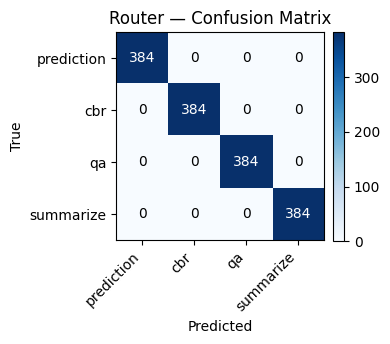

In [ ]:
plt.figure(figsize=(4, 4))
im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Router — Confusion Matrix")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)

# Make text color adapt to background for readability
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar(im, fraction=0.046, pad=0.04)  
plt.tight_layout()
plt.show()

---
## Query Execution Helpers for DLQR

This section defines helper utilities for **executing a single query** through the  
Dynamic LLM Query Router (DLQR) pipeline.  

It provides:
- JSON-safe stringification for inputs  
- Flexible coercion of `explicit_action` into the standard `Action` enum  
- Robust construction of `RouteRequest` objects (with introspection fallback)  
- Ensures router models are loaded before execution  
- Unified entry point `execute_query()` with multiple fallback strategies  

### JSON Stringifier

* Ensures all inputs are stringified before passing to the router.
* If input is a dict or list, tries json.dumps; otherwise falls back to str().
* Guarantees router always receives a safe string (prevents serialization errors).

In [ ]:
def _jsonify(x: Any) -> str:
    """Safe-ish stringify: dict/list -> JSON; other -> str()."""
    if isinstance(x, (dict, list)):
        try:
            return json.dumps(x, ensure_ascii=False)
        except Exception:
            return str(x)
    return str(x) if x is not None else ""

### Explicit Action Coercion

* Handles different user inputs for explicit routing action:
    * None → no explicit override
	* Action enum-like object → returned directly
	* int → looked up in LABEL2ID inverse map
	* str → lowercased and converted into Action enum
* Raises ValueError for unknown or invalid action names/IDs.

In [ ]:
def _coerce_action(explicit_action: Optional[Union[str, int, Any]]) -> Optional[Any]:
    """
    Convert str/int/enum-like to your Action enum instance, or None.
    - str: case-insensitive; supports label names (e.g. 'prediction')
    - int: maps via inverse of LABEL2ID if available
    - enum: passed through (if it has .value we assume it's already Action)
    """
    if explicit_action is None:
        return None

    # Already enum-like?
    if hasattr(explicit_action, "value"):
        return explicit_action  # assume Action

    # Int -> id2label -> Action
    if isinstance(explicit_action, int):
        try:
            id2label = {v: k for k, v in LABEL2ID.items()}
            name = id2label[int(explicit_action)]
            return Action(name.lower())
        except Exception as e:
            raise ValueError(
                f"Unknown explicit_action id: {explicit_action}. Valid ids: {sorted(LABEL2ID.values())}"
            ) from e

    # String label
    if isinstance(explicit_action, str):
        name = explicit_action.strip().lower()
        try:
            return Action(name)
        except Exception as e:
            valid = ", ".join(sorted(getattr(Action, "__members__", {}).keys())) or "prediction|cbr|qa|summarize"
            raise ValueError(f"Unknown action: {explicit_action!r}. Use one of: {valid}") from e

    # Unknown type
    raise ValueError(
        "explicit_action must be None, str label, int id, or Action enum."
    )

### RouteRequest Builder

* Uses Python inspect.signature to introspect RouteRequest constructor.
* Builds payload dynamically so that only supported fields are included.
* Falls back to positional instantiation if keyword-based construction fails.
* Ensures compatibility across different versions of the router API.

In [ ]:
def _build_request(query_str: str, context_str: Optional[str], explicit: Optional[Any], *, trace: bool=False):
    """
    Create a RouteRequest, being tolerant to different constructor signatures.
    Known fields: query, context_text, explicit_action, (maybe) trace
    """
    # Introspect RouteRequest to only pass supported kwargs
    try:
        sig = inspect.signature(RouteRequest)
        params = set(sig.parameters.keys())
    except Exception:
        params = {"query", "context_text", "explicit_action"}  # best-guess

    payload = {}
    if "query" in params:
        payload["query"] = query_str
    if "context_text" in params:
        payload["context_text"] = context_str
    if "explicit_action" in params:
        payload["explicit_action"] = explicit
    if "trace" in params:
        payload["trace"] = bool(trace)

    try:
        return RouteRequest(**payload)
    except Exception:
        # last resort: try positional minimal form
        return RouteRequest(query_str, context_str, explicit)

### Router Loading Helper

* Ensures router model artifacts are loaded once per directory.
* Avoids reloading unless force_reload=True or directory changes.
* Maintains global variable __ROUTER_LOADED_FROM_DIR for tracking.

In [ ]:
__ROUTER_LOADED_FROM_DIR = None
def _ensure_loaded(model_dir: str | None = None, force_reload: bool = False):
    global __ROUTER_LOADED_FROM_DIR
    if model_dir is not None and (force_reload or __ROUTER_LOADED_FROM_DIR != model_dir):
        load_router(model_dir)
        __ROUTER_LOADED_FROM_DIR = model_dir

### Single Query Executor

In [ ]:
# ---------- single query ----------
@torch.no_grad()
def execute_query(
    query: Union[str, dict, list],
    context: Union[str, dict, list, None] = None,
    *,
    model_dir: Optional[str] = None,
    force_reload: bool = False,
    explicit_action: Optional[Union[str, int, Any]] = None,  # e.g. "prediction" or id
    return_full: bool = False,
    trace: bool = False,
) -> Any:
    """
    Run a single query through the notebook executor (nb_execute) after ensuring artifacts are loaded.
    Falls back to route-only result if nb_execute is unavailable.

    Returns:
        - default: the `output` field from nb_execute(...)
        - if return_full=True: the entire execution envelope (dict)
    """
    _ensure_loaded(model_dir, force_reload)

    query_str = _jsonify(query)
    context_str = _jsonify(context) if context is not None else None
    explicit = _coerce_action(explicit_action)

    # Build a tolerant request for nb_execute
    req = _build_request(query_str, context_str, explicit, trace=trace)

    # Prefer nb_execute if available
    if "nb_execute" in globals() and callable(globals()["nb_execute"]):
        start = time.time()
        env = nb_execute(req)  # expected: {"decision": {...}, "output": ..., ...}
        env = env if isinstance(env, dict) else {"output": env}
        env.setdefault("trace_id", str(uuid.uuid4()))
        env.setdefault("timing_sec", time.time() - start)
        return env if return_full else env.get("output")

    # Fallback path: try nb_route → router.route (no tool execution)
    result = {"trace_id": str(uuid.uuid4())}

    if "nb_route" in globals() and callable(globals()["nb_route"]):
        try:
            routed = nb_route(req)
            result["decision"] = routed.get("decision", routed)
        except Exception as e:
            result["decision_error"] = f"nb_route failed: {e}"

    if "decision" not in result:
        # final fallback to raw router.route
        try:
            # IMPORTANT: your Router.route expects explicit=None or Action (not False)
            dec = router.route(query_str, context_str, explicit=None if explicit is None else explicit)
            result["decision"] = {"action": getattr(dec, "value", dec)}
        except Exception as e:
            result["decision_error"] = f"router.route failed: {e}"

    # No tool executed in fallback; return the decision envelope
    return result if return_full else result.get("decision")

In [ ]:
# ===============================
# Pretty Printing & CLI Helpers
# ===============================
# This module provides utilities to render router execution results nicely in either:
# - Rich terminal (if `rich` is available), or
# - Plain stdout fallback.
# It includes specialized renderers for QA, Summarize, Prediction, CBR, and generic outputs,
# plus a `pretty_print_result` entrypoint and an `auto_pretty` convenience wrapper.

from __future__ import annotations

import math
import re
import textwrap
from typing import Any, Dict, List, Optional, Tuple

# --------- optional rich UI ---------
try:
    # Try importing 'rich' for attractive console output. If unavailable, fall back to print().
    from rich.console import Console
    from rich.table import Table
    from rich.panel import Panel
    from rich.text import Text
    from rich import box

    _RICH = True
    console = Console()
except Exception:
    # Rich not installed or failed to import — disable rich UI.
    _RICH = False
    console = None  # type: ignore


# --------- helpers ---------
def _is_nan(x) -> bool:
    # Robust NaN check (avoids exceptions for non-float inputs).
    try:
        return isinstance(x, float) and math.isnan(x)
    except Exception:
        return False


def _fmt(val: Any) -> str:
    # Generic formatter for table cells:
    # - None/NaN as em dash
    # - Floats get compact or fixed precision depending on magnitude
    # - Others -> str()
    if val is None or _is_nan(val):
        return "—"
    if isinstance(val, float):
        return f"{val:.6f}" if abs(val) < 1e-4 or abs(val) > 9_999 else f"{val:.6g}"
    return str(val)


def _shorten(s: str, width: int = 1000) -> str:
    # Truncate long strings for display. Preserves whole-word boundaries with an ellipsis.
    s = (s or "").strip()
    if len(s) <= width:
        return s
    return textwrap.shorten(s, width=width, placeholder=" …")


def _decision(meta: Dict[str, Any] | None) -> Tuple[Optional[str], Optional[str]]:
    """Extract (chosen/action, target_id) from a decision blob."""
    dec = meta or {}
    chosen = dec.get("chosen", dec.get("action"))
    target = dec.get("target_id")
    return chosen, target


def _print_header(title: str, color: str = "cyan") -> None:
    # Print a section header (Rich panel if available; plain fallback otherwise).
    if _RICH:
        console.print(Panel(Text(title, style="bold white"), border_style=color, expand=False))
    else:
        print(f"\n=== {title} ===")


def _print_kv_table(pairs: List[Tuple[str, Any]], accent: str = "cyan") -> None:
    # Render key-value pairs in a compact 2-column table (Rich) or simple "k: v" lines.
    if _RICH:
        tbl = Table(box=box.MINIMAL_DOUBLE_HEAD, show_header=False, pad_edge=False)
        tbl.add_column("k", style=f"bold {accent}", no_wrap=True)
        tbl.add_column("v", style="white")
        for k, v in pairs:
            tbl.add_row(str(k), _fmt(v))
        console.print(tbl)
    else:
        for k, v in pairs:
            print(f"{k}: {_fmt(v)}")


def _list_of_dicts_table(rows: List[Dict[str, Any]], title: str | None = None) -> None:
    """Render list-of-dicts as a table. Silent if empty (avoids noise)."""
    if not rows:
        return

    # Gather all keys across rows in first-seen order to define columns.
    keys: List[str] = []
    seen = set()
    for r in rows:
        for k in r.keys():
            if k not in seen:
                seen.add(k)
                keys.append(k)

    if _RICH:
        # Pretty table with discovered columns.
        tbl = Table(*[k.upper() for k in keys], box=box.SIMPLE_HEAVY, title=title)
        for r in rows:
            tbl.add_row(*[_fmt(r.get(k)) for k in keys])
        console.print(tbl)
    else:
        # Plain-text fallback, enumerating rows for readability.
        if title:
            print(f"\n{title}:")
        for i, r in enumerate(rows, 1):
            print(f"  #{i}")
            for k in keys:
                print(f"    - {k}: {_fmt(r.get(k))}")


def _maybe_split_points(text: str) -> List[str]:
    # Attempt to split summaries into bullet points. Handles:
    # - Multi-line lists
    # - Single line with "1. ... 2. ... - ... • ..." patterns
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if len(lines) == 1:
        bullets = re.split(r"\s*(?:\d+[\.\)]|[-•])\s+", lines[0])
        bullets = [b for b in bullets if b]
        if len(bullets) > 1:
            return bullets
    return lines


def _pick(d: Dict[str, Any], keys: List[str]) -> Any:
    # Return the first present key's value from dict `d`, else None.
    for k in keys:
        if k in d:
            return d[k]
    return None


def _pct(x: Any) -> str:
    """
    Format numeric as percentage. Strings pass through (e.g., '99.9%').
    [0,1] → prob; otherwise treated as already-percent value.
    """
    try:
        if isinstance(x, str):
            return x
        fx = float(x)
        if 0.0 <= fx <= 1.0:
            return f"{fx * 100:.2f}%"
        return f"{fx:.2f}%"
    except Exception:
        return str(x)


# --- helper: parse numeric prob for sorting ---
def _to_prob_float(v) -> float | None:
    # Normalize probabilities provided as '0.87', 0.87, '87%', or 87.
    try:
        if isinstance(v, str) and v.strip().endswith("%"):
            return float(v.strip().strip("%")) / 100.0
        f = float(v)
        if 0.0 <= f <= 1.0:
            return f
        return f / 100.0  # assume 0–100 numeric → convert to 0–1
    except Exception:
        return None


# --------- specialized renderers ---------
def _render_qa(output: Any) -> None:
    # Render QA-style text in a panel or plain section.
    text = _shorten(str(output), 2000)
    if _RICH:
        console.print(Panel(text, title="Answer", border_style="green"))
    else:
        print("Answer:")
        print(text)


def _render_summary(output: Any) -> None:
    # Render summaries as enumerated key points (list or heuristically split text).
    points: List[str]
    if isinstance(output, list):
        points = [str(p).strip() for p in output if str(p).strip()]
    else:
        points = _maybe_split_points(str(output))

    if _RICH:
        tbl = Table("#", "KEY POINT", box=box.SIMPLE_HEAVY)
        for i, p in enumerate(points, 1):
            tbl.add_row(str(i), _shorten(p, 300))
        console.print(tbl)
    else:
        print("Key Points:")
        for i, p in enumerate(points, 1):
            print(f"  {i}. {p}")


def _render_prediction_like(output: Dict[str, Any]) -> None:
    """
    Prediction-style renderer:
      - Predicted Diagnosis (or aliases)
      - Confidence (if present; formats to %)
      - Class Probabilities as a neat table (sorted desc)
    """
    # Accept multiple possible keys to be resilient to different tool outputs.
    diagnosis = _pick(output, ["Predicted Diagnosis", "Suggested Diagnosis", "diagnosis", "label", "prediction"])
    confidence = _pick(output, ["Confidence", "confidence", "conf", "score", "probability"])
    class_probs = _pick(
        output,
        ["Class Probabilities", "class_probabilities", "probs", "class_probs", "probabilities"],
    )

    # Normalize probabilities to rows: (label, pct_str, float_prob_for_sort)
    prob_rows: List[Tuple[str, str, Optional[float]]] = []
    if isinstance(class_probs, dict):
        for k, v in class_probs.items():
            prob_rows.append((str(k), _pct(v), _to_prob_float(v)))
    elif isinstance(class_probs, list):
        # Support list-of-tuples like [("OSCC", 0.9997), ...]
        try:
            for k, v in class_probs:
                prob_rows.append((str(k), _pct(v), _to_prob_float(v)))
        except Exception:
            prob_rows = []

    # Sort: valid numbers first, highest-to-lowest; unknowns last.
    prob_rows.sort(key=lambda t: (t[2] is None, -(t[2] or -1.0)))

    if _RICH:
        # Build a compact grid with a nested table for probabilities.
        grid = Table.grid(padding=(0, 1))
        grid.add_column(justify="right", style="bold")
        grid.add_column()

        if diagnosis is not None:
            grid.add_row("Predicted Diagnosis", _fmt(diagnosis))
        if confidence is not None:
            grid.add_row("Confidence", _pct(confidence))

        if prob_rows:
            probs_tbl = Table("Class", "Probability", box=box.SIMPLE_HEAVY, show_header=True)
            for label, pct_s, _ in prob_rows:
                probs_tbl.add_row(label, pct_s)
            grid.add_row("Class Probabilities", probs_tbl)

        console.print(Panel(grid, title="Prediction", border_style="yellow"))
    else:
        # Plain-text fallback
        if diagnosis is not None:
            print(f"Predicted Diagnosis: {_fmt(diagnosis)}")
        if confidence is not None:
            print(f"Confidence: {_pct(confidence)}")
        if prob_rows:
            print("Class Probabilities:")
            for label, pct_s, _ in prob_rows:
                print(f"  - {label}: {pct_s}")


def _render_cbr_like(output: Dict[str, Any]) -> None:
    """
    Minimal CBR renderer (mirrors prediction style for 'Suggested Diagnosis' + similar cases).
    """
    diagnosis = _pick(output, ["Suggested Diagnosis", "Predicted Diagnosis", "diagnosis", "label", "prediction"])
    similar = _pick(
        output,
        ["Top 3 Similar Cases", "Top-3 Similar Cases", "Top Similar Cases", "similar_cases", "neighbors"],
    )

    if _RICH:
        console.print(Panel(_fmt(diagnosis), title="Suggested Diagnosis", border_style="yellow"))
        if isinstance(similar, list) and similar:
            _list_of_dicts_table(similar, title="Top 3 Similar Cases")
    else:
        print(f"Suggested Diagnosis: {_fmt(diagnosis)}")
        if isinstance(similar, list) and similar:
            _list_of_dicts_table(similar, title="Top 3 Similar Cases")


def _render_rag_like(output: Dict[str, Any]) -> None:
    # Heuristic renderer for RAG-like outputs with sources.
    answer = output.get("answer") or output.get("response") or output.get("summary") or output.get("text")
    sources = output.get("sources") or output.get("citations") or output.get("documents") or []
    _render_qa(answer)
    if isinstance(sources, list) and sources:
        norm: List[Dict[str, Any]] = []
        for s in sources:
            if isinstance(s, dict):
                norm.append(
                    {
                        "title": s.get("title") or s.get("name") or "—",
                        "url": s.get("url") or s.get("link") or "—",
                        "score": s.get("score") or s.get("similarity") or "—",
                    }
                )
            else:
                norm.append({"title": str(s), "url": "—", "score": "—"})
        _list_of_dicts_table(norm, title="Sources")


def _render_generic(output: Any) -> None:
    # Generic renderer for dict/list/scalar outputs.
    if isinstance(output, dict):
        # Separate nested list-of-dicts for tabular rendering.
        lists = {k: v for k, v in output.items() if isinstance(v, list) and v and isinstance(v[0], dict)}
        scalars = [(k, v) for k, v in output.items() if k not in lists]

        if scalars:
            _print_kv_table(scalars, accent="white")
        for k, rows in lists.items():
            _list_of_dicts_table(rows, title=str(k))
    elif isinstance(output, list):
        if output and isinstance(output[0], dict):
            _list_of_dicts_table(output)
        else:
            if _RICH:
                tbl = Table("#", "ITEM", box=box.SIMPLE_HEAVY)
                for i, item in enumerate(output, 1):
                    tbl.add_row(str(i), _fmt(item))
                console.print(tbl)
            else:
                for i, item in enumerate(output, 1):
                    print(f"  {i}. {_fmt(item)}")
    else:
        # Scalar or unknown type → treat as QA-style text.
        _render_qa(output)


# --------- main entrypoint ---------
def pretty_print_result(
    full: Dict[str, Any],
    title: str = "Execution",
    *,
    show_decision: bool = False,
) -> None:
    """
    Pretty-print an execute_query(...) result regardless of action/output shape.

    Args:
        full: The result dict, usually with 'decision' and 'output' keys.
        title: Header title (kept as-is). Pass a better string to avoid odd titles.
        show_decision: If True, also prints a small 'Decision' card (Chosen/Target).
    """
    # Defensive extraction of action metadata.
    dec = full.get("decision", {}) if isinstance(full, dict) else {}
    chosen, target = _decision(dec)

    # Header
    _print_header(title, color="cyan")

    # Optional decision card showing the selected action and target id (if any).
    if show_decision:
        _print_kv_table([("Chosen", chosen), ("Target", target)], accent="cyan")

    # Extract the tool output payload
    output = full.get("output", None)

    # Robust action detection (case/format insensitive)
    action = (chosen or "")
    action_upper = action.upper() if isinstance(action, str) else ""

    try:
        # Specialized renderers by action
        if "QA" in action_upper:
            _render_qa(output)
        elif "SUMMARIZE" in action_upper:
            _render_summary(output)
        elif "PREDICT" in action_upper or "PREDICTION" in action_upper:
            if isinstance(output, dict):
                _render_prediction_like(output)
            else:
                _render_generic(output)
        elif "CBR" in action_upper:
            if isinstance(output, dict):
                _render_cbr_like(output)
            else:
                _render_generic(output)
        # Heuristic: some RAG engines return dicts with 'answer'/'sources'
        elif isinstance(output, dict) and any(k in output for k in ("answer", "sources", "citations", "documents")):
            _render_rag_like(output)
        else:
            # Fallback renderer
            _render_generic(output)
    except Exception as e:
        # Never let rendering errors crash the app; show raw output.
        if _RICH:
            console.print(Panel(f"Render error: {e}", border_style="red"))
            console.print(Panel(_shorten(str(output), 2000), title="Raw Output"))
        else:
            print(f"[Render error: {e}]")
            print("Raw Output:")
            print(_shorten(str(output), 2000))



# --- Post-call auto pretty ---
def auto_pretty(full):
    """Infer a nice title from 'decision' and pretty-print the result."""
    # Extract 'chosen'/'action' and build a pleasant title per action.
    dec = full.get("decision", {}) if isinstance(full, dict) else {}
    act = (dec.get("chosen", dec.get("action")) or "").upper()
    title = {
        "ACTION.QA": "QA Execution",
        "QA": "QA Execution",
        "ACTION.SUMMARIZE": "SUMMARIZE Execution",
        "SUMMARIZE": "SUMMARIZE Execution",
        "ACTION.prediction": "Prediction Execution",
        "prediction": "Prediction Execution",
        "ACTION.CBR": "CBR Execution",
        "CBR": "CBR Execution",
    }.get(act, "Execution")
    pretty_print_result(full, title=title)

In [ ]:
# -------------------------------
# Example executions + pretty UI
# -------------------------------
# Each example runs a query via `execute_query(..., return_full=True)` to obtain
# a full envelope (decision, output, trace) and then pretty-prints the result.

exc_full = execute_query(
    "SUMMARIZE the OSCC clinical context and biomarker profile into key points",
    model_dir=MODEL_DIR,
    return_full=True
)
auto_pretty(exc_full)

╭─────────────────────╮
│ SUMMARIZE Execution │
╰─────────────────────╯

 #   KEY POINT                                                                                                    
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  1   * The dataset contains patient records for individuals presenting with oral cancer symptoms, specifically    
      non-healing ulcers or masses in the oral cavity.                                                             
  2   * The patients' ages range from 32 to 81 years old, and ethnicities include Black/African, Other, and not    
      specified.                                                                                                   
  3   * Biomarker analysis reports suggest a high likelihood of malignancy based on elevated levels of specific    
      markers in saliva, blood, and urine. These markers include Mirna 21, Cyfra 21 1, Scc Ag, Il 6, and Cea.      
  4   * Elevated levels of creatinine and urea in the urine are also commonly observed.                            
  5   * The presence of these markers indicates a head and neck primary site for the malignancy.                   
  6   * The patients have a history of long-term tobacco use (2 PPD x 30 years), smokeless tobacco use, and        
      significant alcohol consumption.                                                                             
  7   * The physical examination reveals ulcerated or exophytic masses in various locations within the oral        
      cavity. Associated symptoms include odynophagia (painful swallowing).                                        
  8   * Palpable lymph nodes are noted in some cases.                                                              
  9   * The assessment and plan for each patient involve suspicion of SCC, biopsy of the primary lesion, and       
      fine-needle aspiration of cervical lymph nodes where appropriate.

In [ ]:
exc_full = execute_query(
    "What are the side effects of cisplatin?",
    model_dir=MODEL_DIR,
    return_full=True
)
auto_pretty(exc_full)

╭──────────────╮
│ QA Execution │
╰──────────────╯

╭──────────────────────────────────────────────────── Answer ─────────────────────────────────────────────────────╮
│ Cisplatin is a chemotherapeutic agent commonly used in the treatment of various cancers, including head and     │
│ neck cancer. Some common side effects associated with cisplatin use may include nausea, vomiting, loss of       │
│ appetite, kidney damage (due to increased creatinine levels), hearing loss or tinnitus (ringing in the ears),   │
│ peripheral neuropathy (numbness, tingling or pain in hands and feet), mouth sores, and anemia. Additionally,    │
│ cisplatin may cause hair loss and increase the risk of developing secondary cancers later on. It is important   │
│ to discuss potential side effects with a healthcare provider before starting treatment.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
exc_full = execute_query(
    "predict",{
        "Age": 65, "Gender": "Female", "Smoking_Status": "Former", "Cancer_Stage": "Stage II",
        "IL6_Saliva": 14.5, "IL8_Saliva": 21.2, "TNFa_Saliva": None, "LDH_Saliva": 6.8
    },
    model_dir=MODEL_DIR,
    return_full=True
)
auto_pretty(exc_full)

╭───────────╮
│ Execution │
╰───────────╯

╭────────────────────────────────────────────────── Prediction ───────────────────────────────────────────────────╮
│ Predicted Diagnosis OSCC                                                                                        │
│          Confidence 99.97%                                                                                      │
│ Class Probabilities                                                                                             │
│                       Class             Probability                                                             │
│                      ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                                                            │
│                       OSCC              99.97%                                                                  │
│                       Benign Lesion     0.03%                                                                   │
│                       Healthy Control   0.00%                                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## 14) Reproducibility & Appendix
- Seeds set via `RANDOM_SEED`.  
- Deterministic CPU tokenizers.  
- Print key package versions for auditability.

In [ ]:
import importlib
def _ver(pkg):
    try:
        return importlib.import_module(pkg).__version__
    except Exception:
        return "n/a"
print({
    "python": sys.version.split()[0],
    "numpy": _ver("numpy"),
    "pandas": _ver("pandas"),
    "sklearn": _ver("sklearn"),
    "torch": _ver("torch"),
    "transformers": _ver("transformers"),
    "sentence_transformers": _ver("sentence_transformers"),
    "faiss": _ver("faiss"),
    "llama_index": _ver("llama_index"),
})